In [208]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [209]:
df = pd.read_csv('data/final_combined_dataset.csv')

In [210]:
# geocode_list = [3303807]
# df = df[df['geocode'].isin(geocode_list)]

In [211]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])

# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# sum of cases each year
cases_sum = df.groupby(['year'])['cases'].sum().reset_index()

print(cases_sum)

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

    year   cases
0   2012  254010
1   2013  256911
2   2014   15150
3   2015   94824
4   2016  112646
5   2017   17257
6   2018   25184
7   2019   50378
8   2020    8021
9   2021    5445
10  2022   23100


In [212]:
# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[0, 1])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(data, group_col='city', target_col=weather_columns, lags=[0, 1, 2, 3, 4])

# data = create_lags(data, group_col='city', target_col='nearby_cases_weighted', lags=[4])

# lag cases -4 weeks
data = create_lags(data, group_col='city', target_col='cases', lags=[-2], inplace = True)

data = data.dropna().reset_index(drop=True)

In [213]:
# Step 4: Scale continuous variables, including lagged variables
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

continuous_vars = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging',
                   'nearby_cases_weighted']
# Include lagged variables in the scaling process
lagged_vars = [col for col in data.columns if any(lag in col for lag in ['_lag1', '_lag2', '_lag5', '_lag6'])]
scaler_vars = continuous_vars + lagged_vars
# data[scaler_vars] = feature_scaler.fit_transform(data[scaler_vars])

# Scale the target variable
# scaled_cases = target_scaler.fit_transform(data[['cases']])
# data['scaled_cases'] = scaled_cases

In [214]:
# Step 5: Split the data into training and testing sets based on time
train_data = data[(data['week'] >= 201201) & (data['week'] <= 202052)]
test_data = data[(data['week'] > 202052)]

columns_exclude = ['date', 'cases', 'scaled_cases', 'geocode', 'lat', 'long', 'population', 'cases_per_100k', 'year', 'month']

X_train = train_data[[col for col in data.columns if col not in columns_exclude]]
y_train = train_data['cases']

X_test = test_data[[col for col in data.columns if col not in columns_exclude]]
y_test = test_data['cases']

# scale
X_train[scaler_vars] = feature_scaler.fit_transform(X_train[scaler_vars])
X_test[scaler_vars] = feature_scaler.transform(X_test[scaler_vars])

# scale target
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = target_scaler.transform(y_test.values.reshape(-1, 1))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22996\118571208.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[scaler_vars] = feature_scaler.fit_transform(X_train[scaler_vars])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22996\118571208.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[scaler_vars] = feature_scaler.transform(X_test[scaler_vars])


In [215]:
from sklearn.preprocessing import LabelEncoder

# Ensure you're working with a copy of the DataFrame if necessary
X_train = X_train.copy()  # If it's a slice, we create a new copy
X_test = X_test.copy()    # Same here

# Step 1: Encode the city column
label_encoder = LabelEncoder()
X_train['city_encoded'] = label_encoder.fit_transform(X_train['city'])
X_test['city_encoded'] = label_encoder.transform(X_test['city'])

# Step 2: Drop the original city column
X_train = X_train.drop(columns=['city'])
X_test = X_test.drop(columns=['city'])

In [216]:
# Step 6: Prepare LightGBM datasets
train_dataset = lgb.Dataset(X_train, label=y_train)
test_dataset = lgb.Dataset(X_test, label=y_test, reference=train_dataset)

In [217]:
# Step 7: Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Step 8: Train the model with early stopping callback
callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
model = lgb.train(params, train_dataset, valid_sets=[train_dataset, test_dataset],
                  num_boost_round=1000, callbacks=callbacks)

# Step 9: Make predictions and evaluate
scaled_predictions = model.predict(X_test, num_iteration=model.best_iteration)
# Inverse transform predictions to original scale
y_pred = target_scaler.inverse_transform(scaled_predictions.reshape(-1, 1))

# Remove negative predictions
y_pred = np.clip(y_pred, 0, None)

# Step 10: Save the model
model.save_model('lightgbm_dengue_model.txt')

C:\Users\ASUS\miniconda3\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")
C:\Users\ASUS\miniconda3\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.32545	valid_1's rmse: 0.0255032
Early stopping, best iteration is:
[95]	training's rmse: 0.327479	valid_1's rmse: 0.025501


Top 10 Most Important Features:
                                    Feature  Importance
19                               cases_lag0         542
20                               cases_lag1         288
0                                      week         124
8                               vim_monthly         122
16                                month_cos         109
7                                       vim         108
17                                 week_sin          95
71                             city_encoded          68
18                                 week_cos          52
54  precipitation_avg_ordinary_kriging_lag3          43


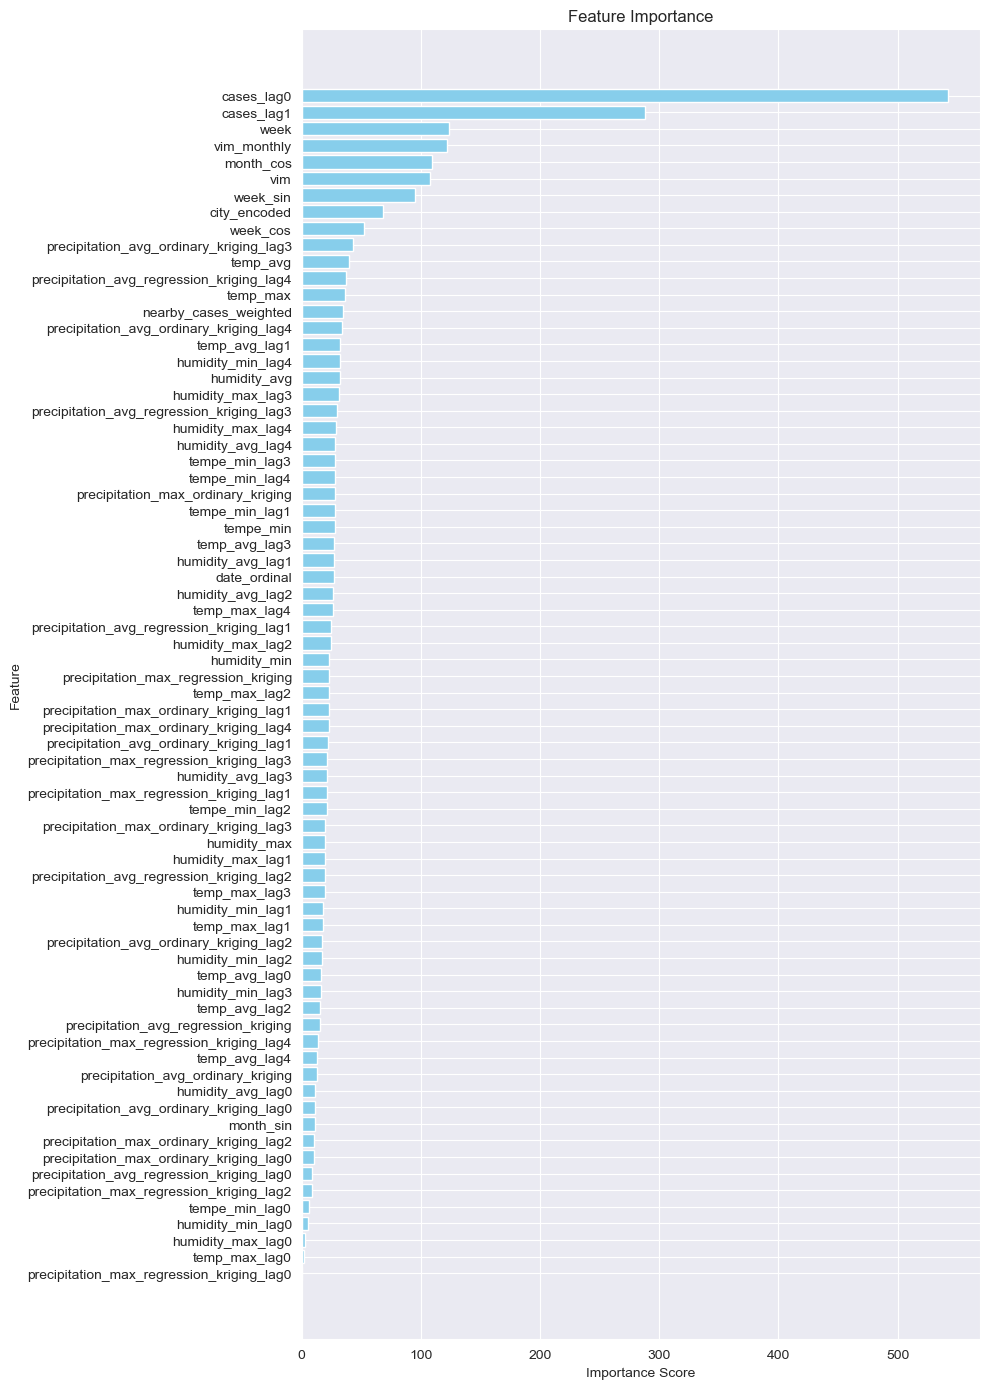

In [218]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for feature importance
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance()
})

# Sort by importance
importance = importance.sort_values(by='Importance', ascending=False)

# Print top features in a neat table
print("Top 10 Most Important Features:")
print(importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 14))
plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.show()


RMSE: 5.821249255070315


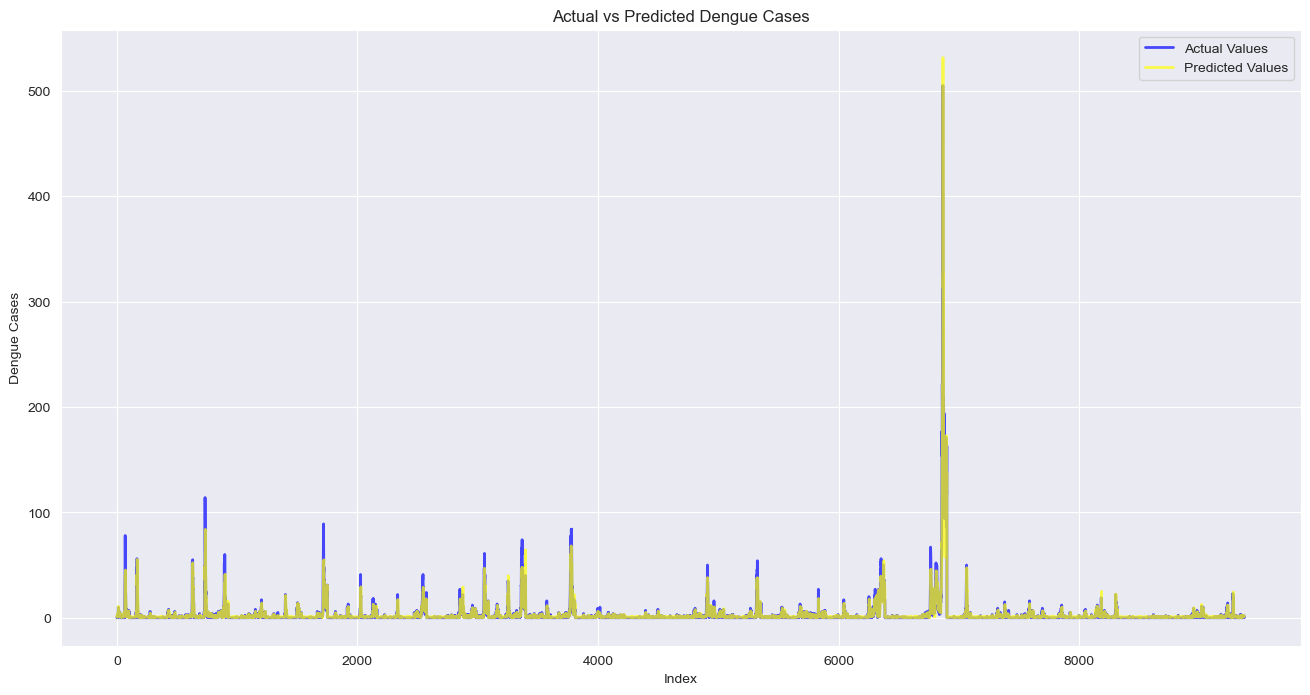

In [219]:
# Step 1: Reshape the actual target values to match the shape of predictions
y_actual = target_scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f'RMSE: {rmse}')

# Step 2: Plot the graph
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(y_actual)), y_actual, label='Actual Values', color='blue', alpha=0.7, linewidth=2)
plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted Values', color='yellow', alpha=0.7, linewidth=2)
plt.xlabel('Index')
plt.ylabel('Dengue Cases')
plt.title('Actual vs Predicted Dengue Cases')
plt.legend()
plt.grid(True)
plt.show()

In [220]:
print(X_test.head())

       week  tempe_min  humidity_max  humidity_avg  humidity_min  temp_avg  \
465  202053  -0.069112      0.075330      0.584279      0.357765 -0.140184   
466  202101  -0.044432      0.044440     -0.768345     -0.620142  0.810066   
467  202102   0.399805      0.076778     -0.459424     -0.352717  0.912592   
468  202103   0.547885     -0.252149     -2.282847     -1.225573  1.684524   
469  202104   0.202366     -0.219894     -2.568561     -1.460963  1.785291   

     temp_max       vim  vim_monthly  precipitation_avg_ordinary_kriging  ...  \
465  0.003289  0.854989     0.850867                            2.166418  ...   
466  0.997895  0.855700     0.858233                            1.080094  ...   
467  0.929301  0.857531     0.858233                            1.462212  ...   
468  1.409456  0.859299     0.858233                           -1.024446  ...   
469  1.615237  0.860919     0.858233                           -1.024446  ...   

     precipitation_avg_regression_kriging_la

City: 0, RMSE: 7.45465505468854


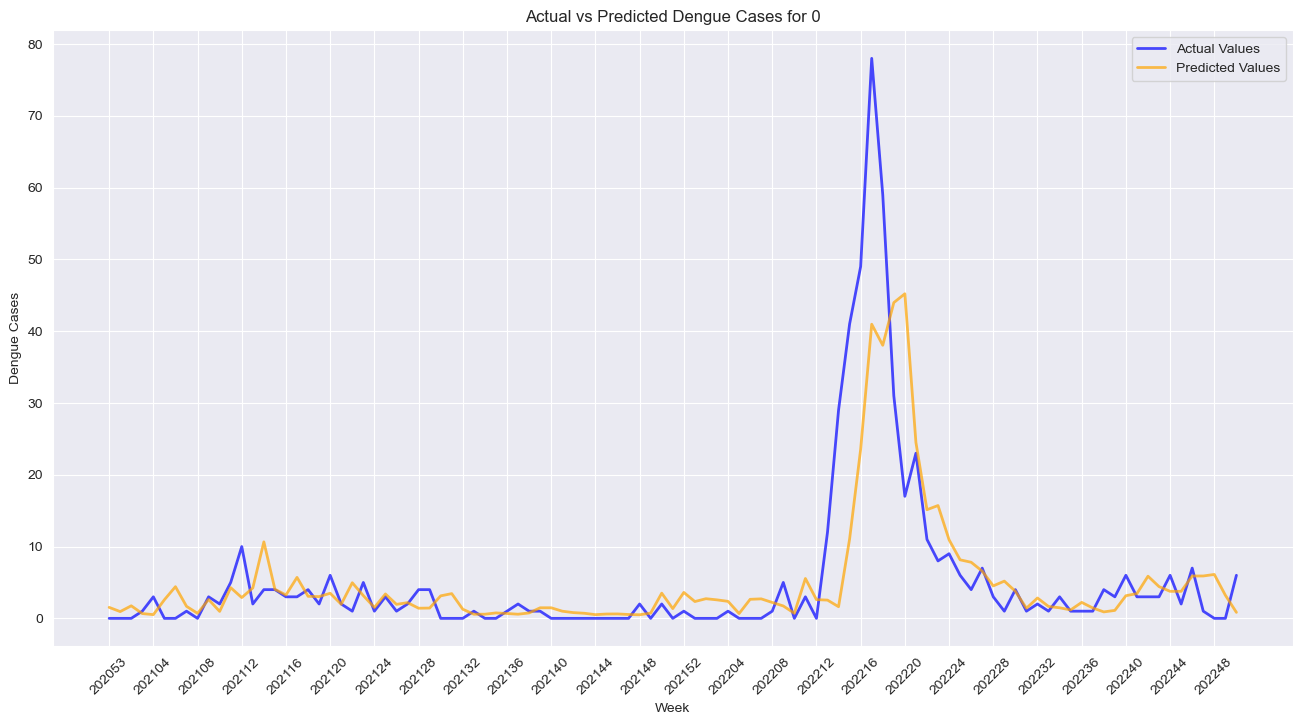

City: 1, RMSE: 5.784651317485066


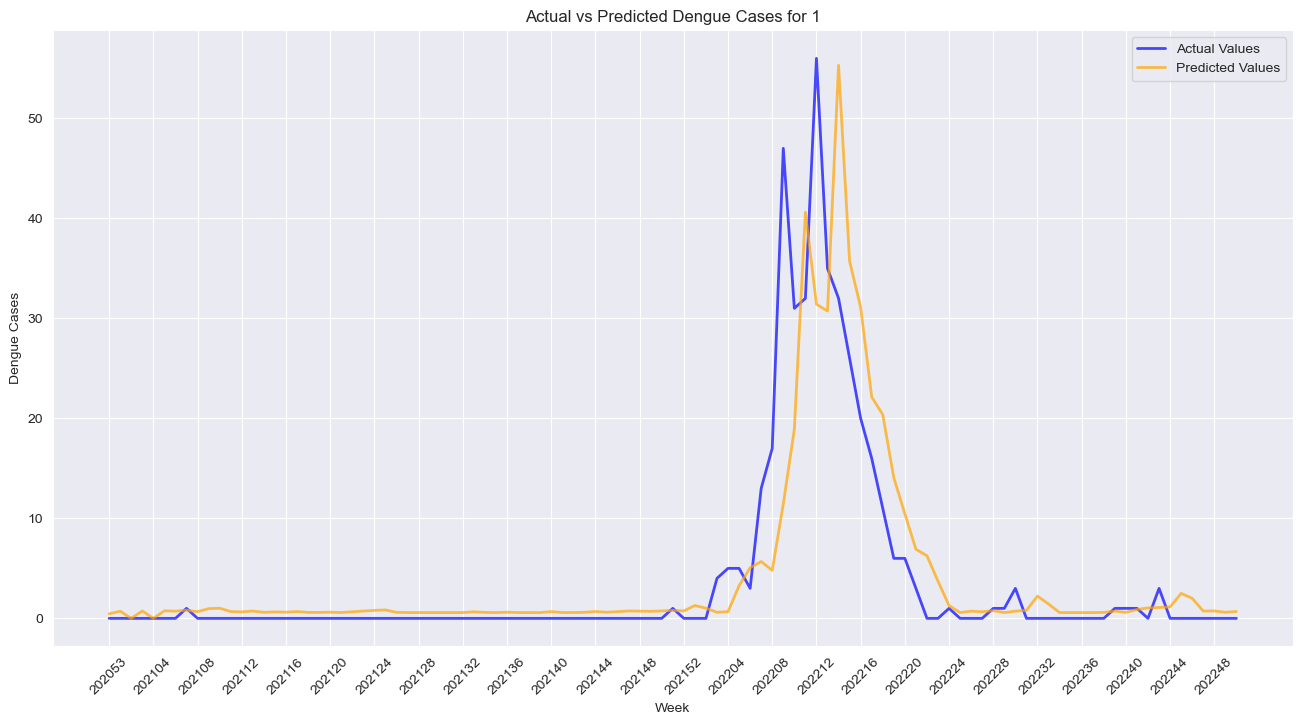

City: 6, RMSE: 5.143189320585021


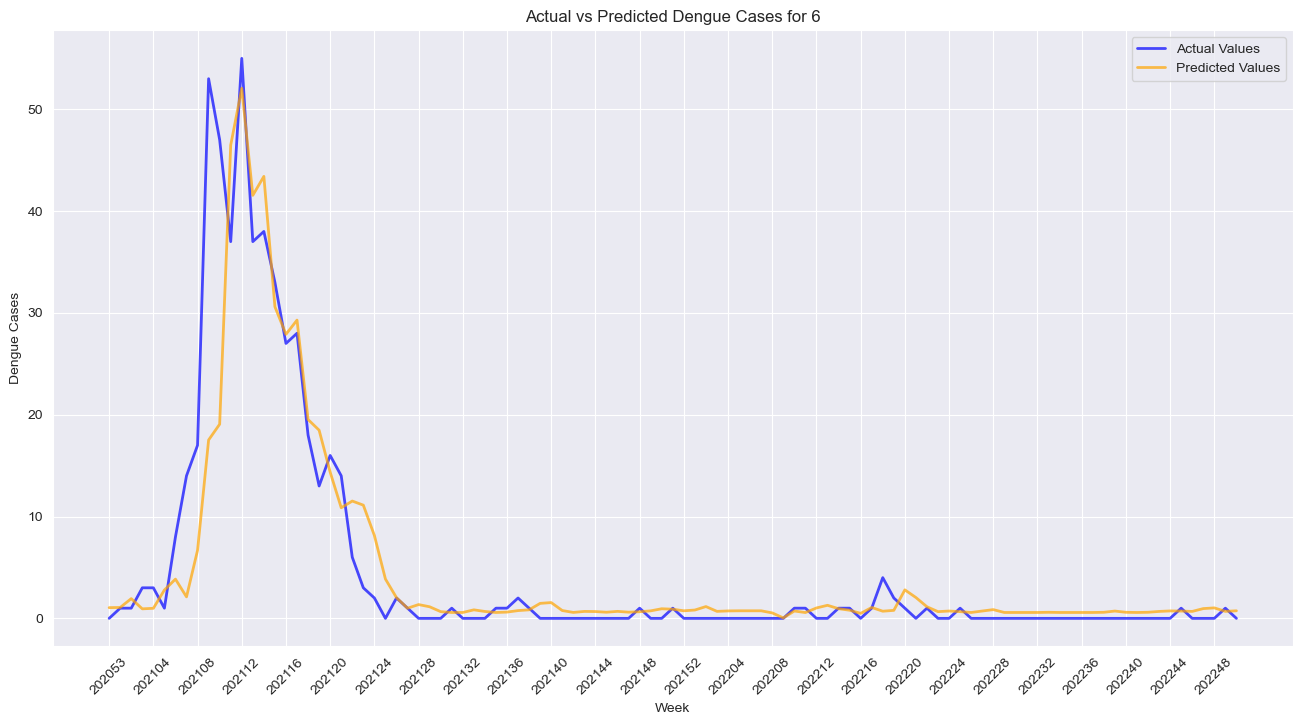

City: 7, RMSE: 10.311227706005898


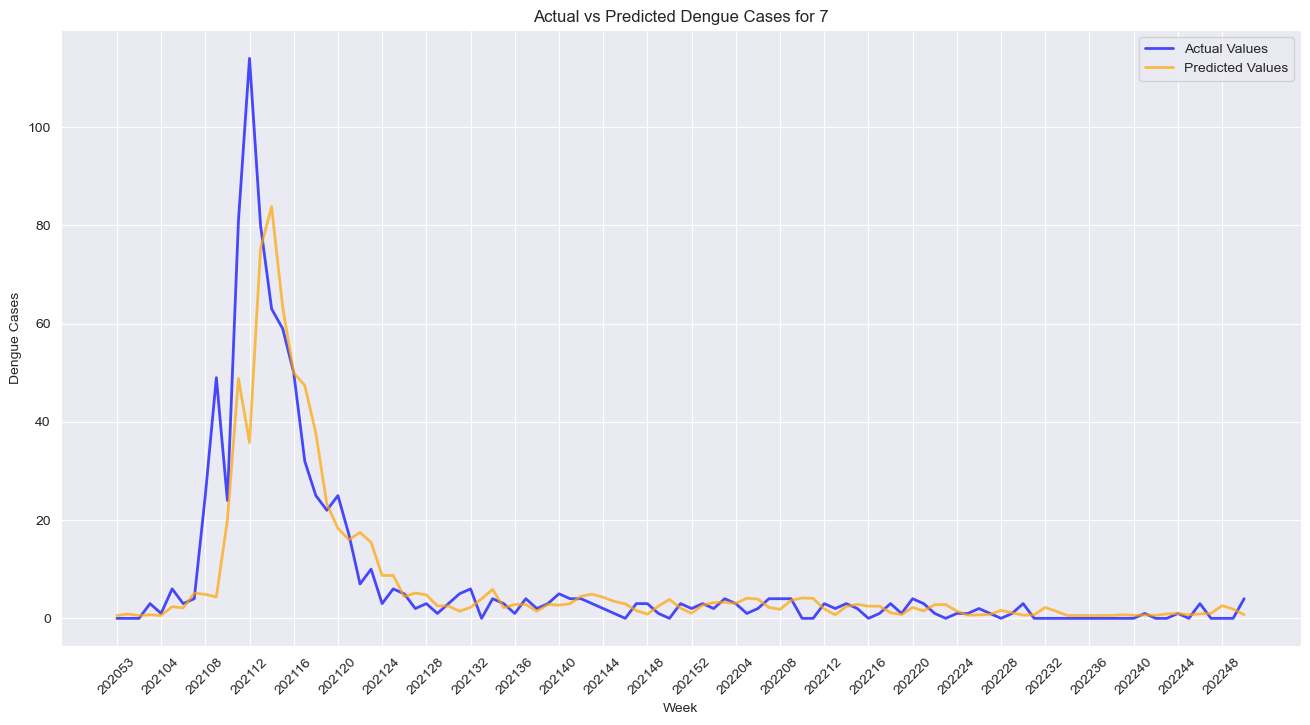

City: 8, RMSE: 7.5168326602752495


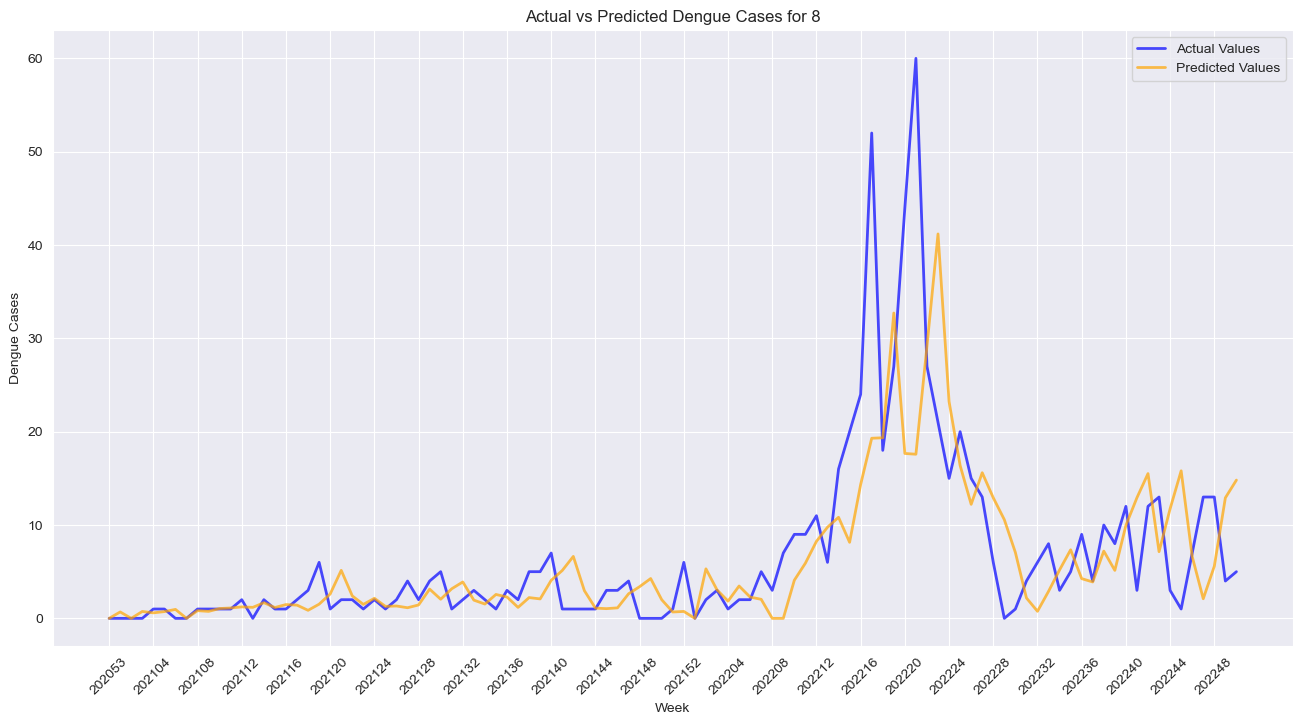

City: 11, RMSE: 2.1849402533897195


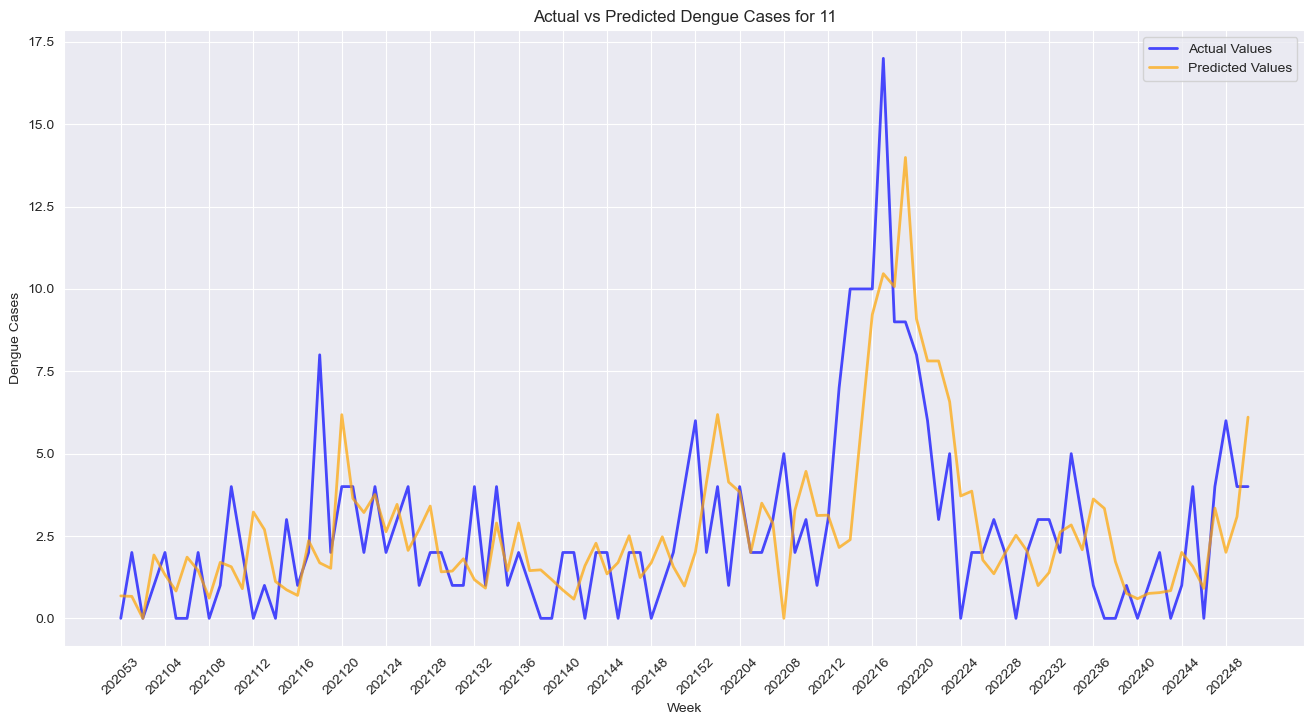

City: 13, RMSE: 2.7386078456174805


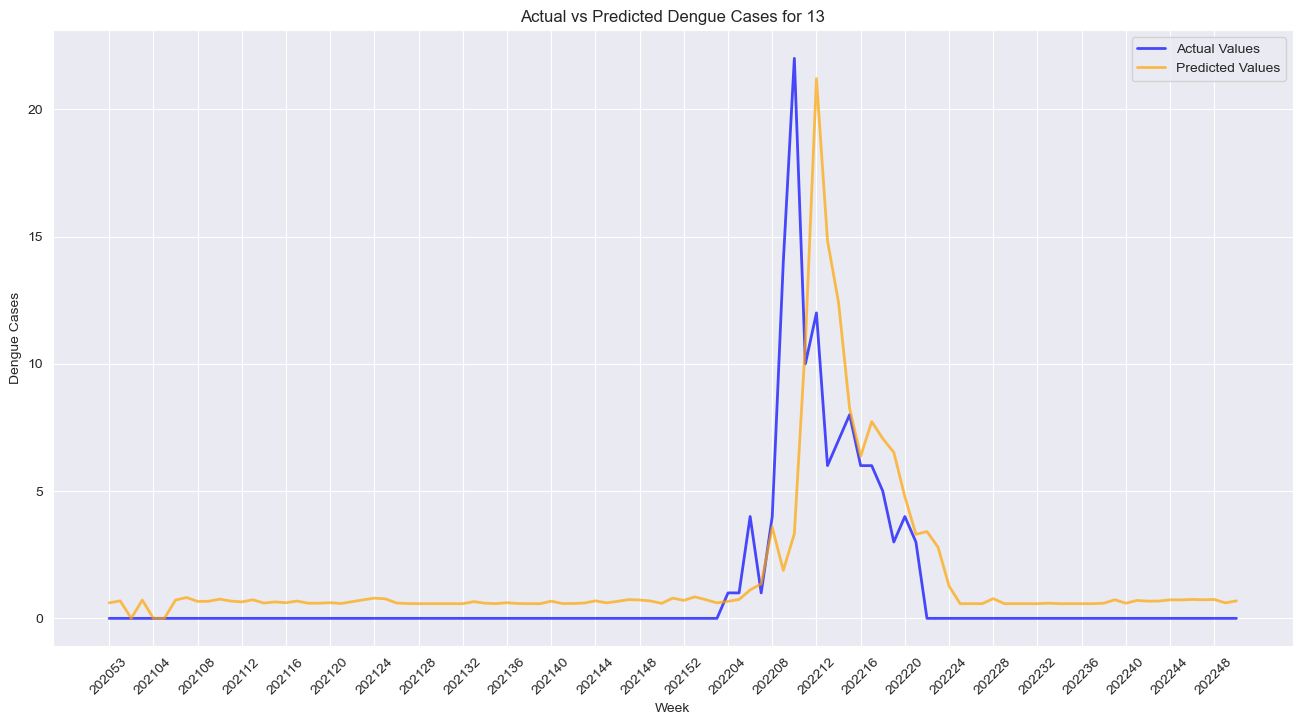

City: 16, RMSE: 2.368057789663755


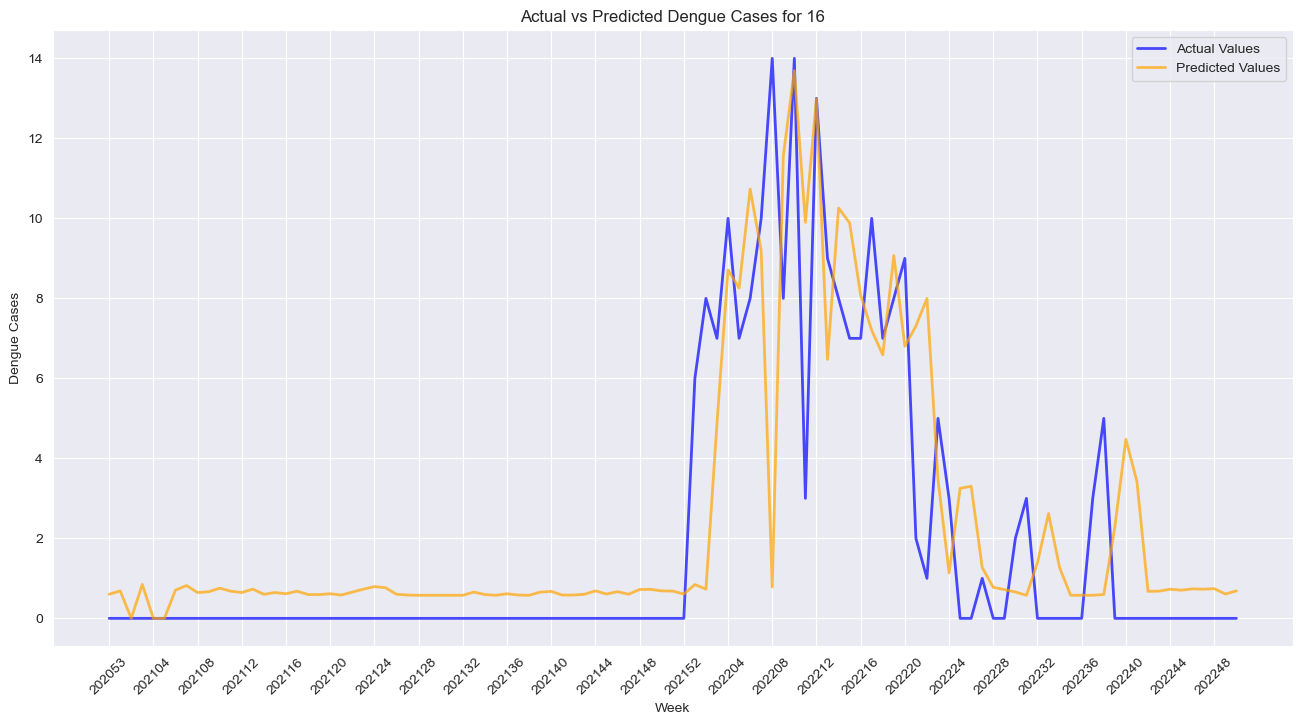

City: 14, RMSE: 8.963618534618146


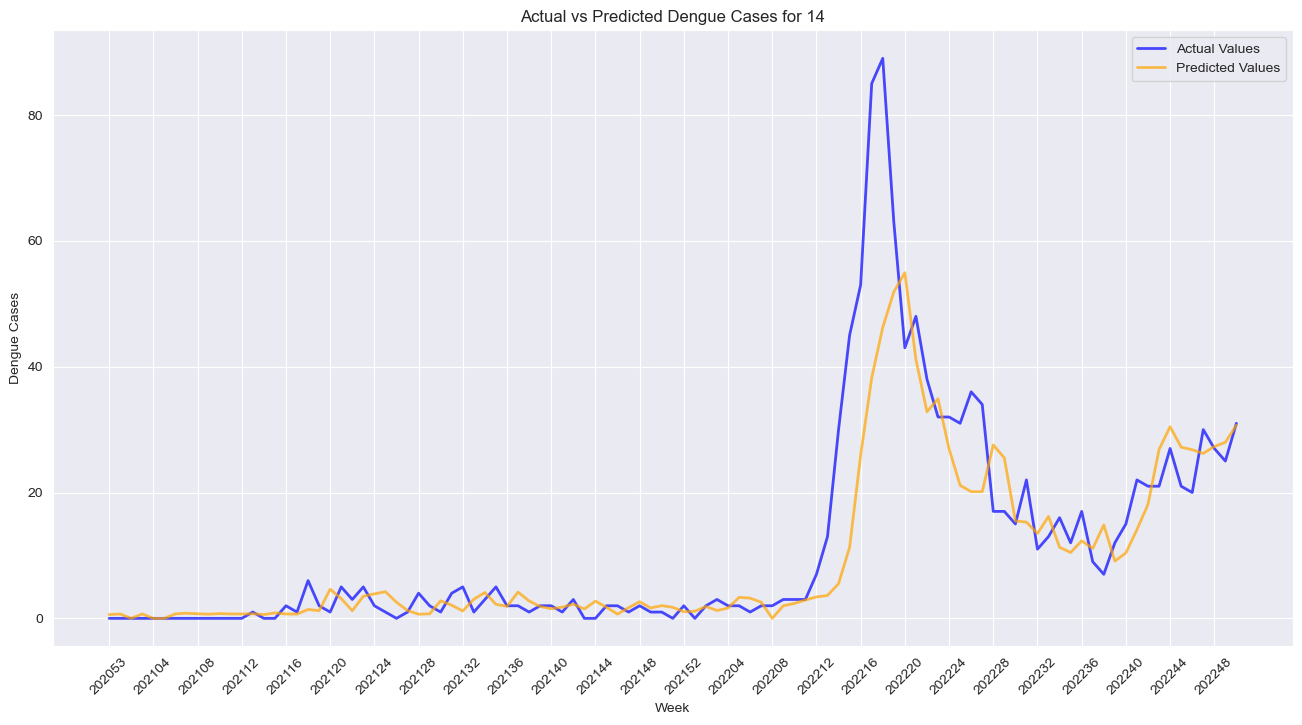

City: 17, RMSE: 1.852857111531977


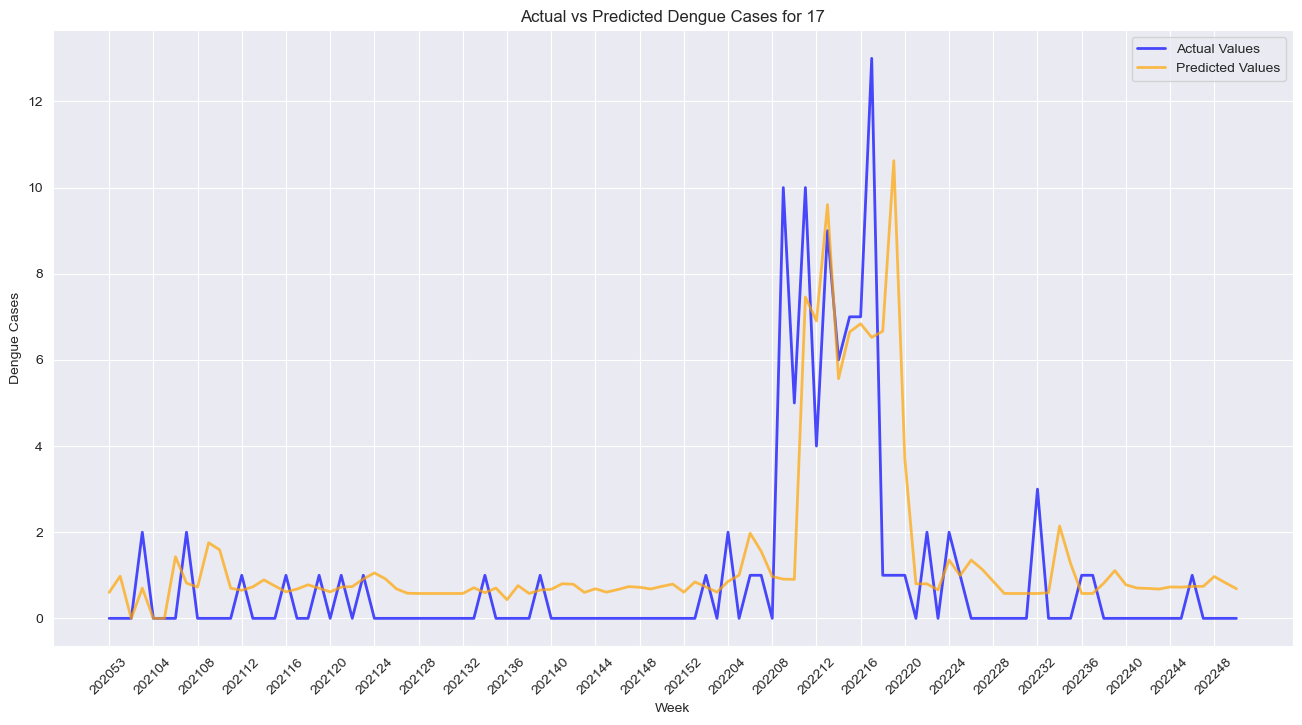

City: 18, RMSE: 4.348915763577357


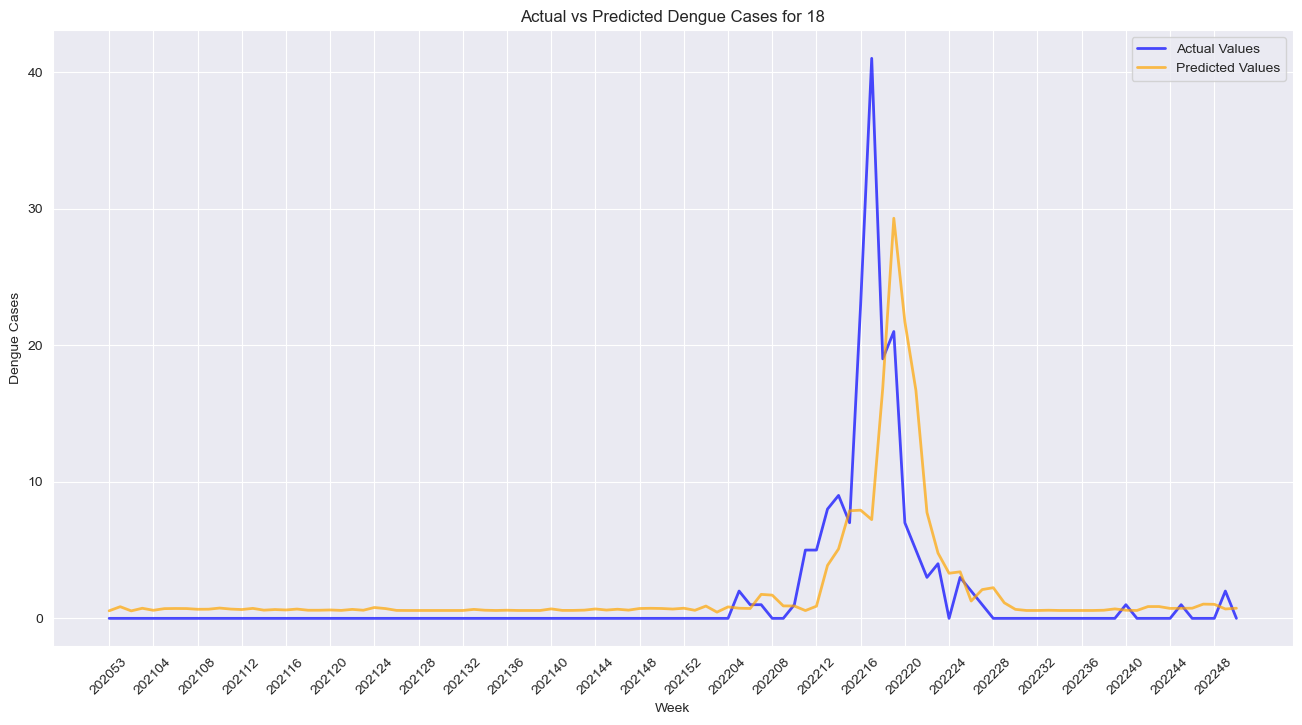

City: 19, RMSE: 3.0230105118235304


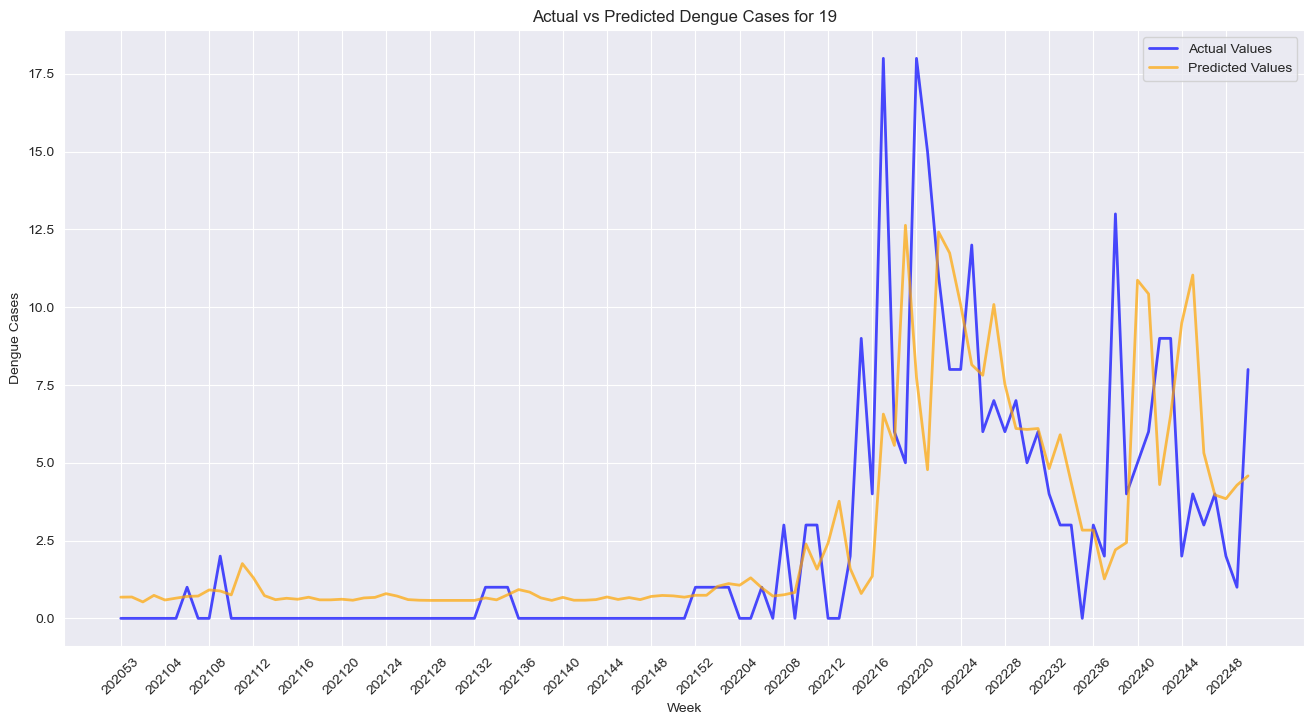

City: 22, RMSE: 2.2380913566779816


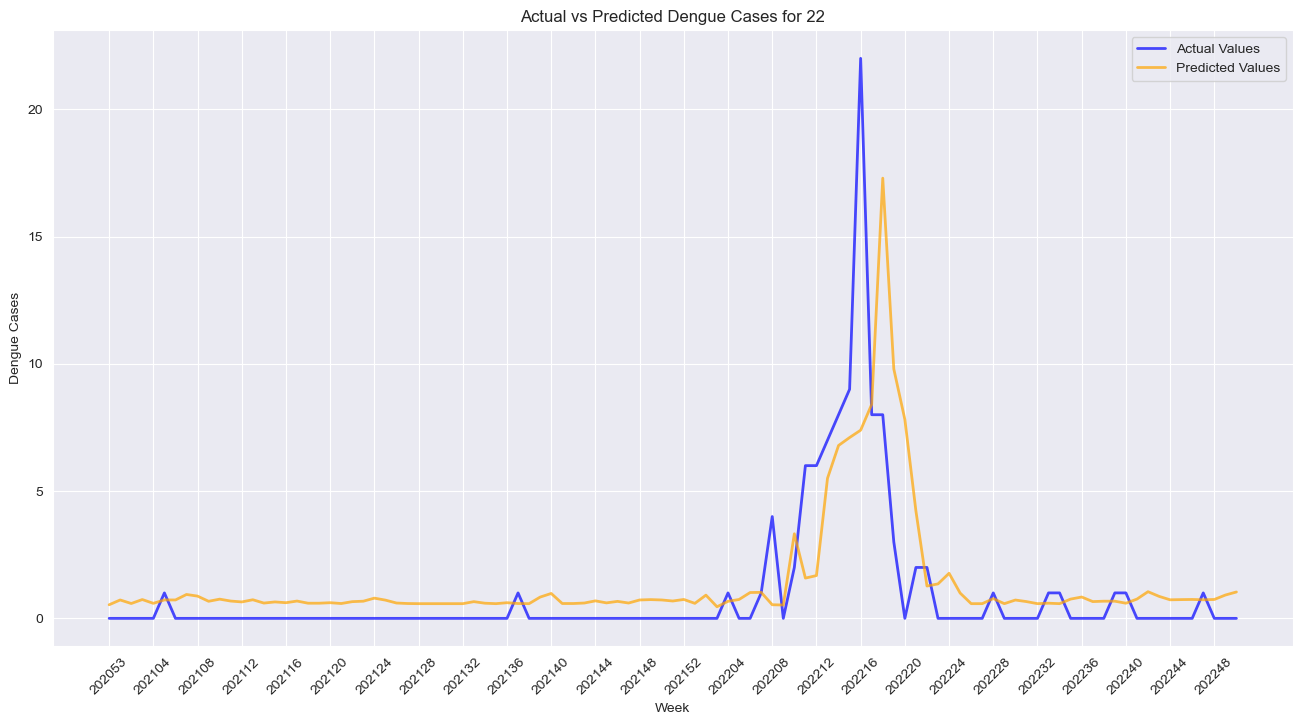

City: 24, RMSE: 5.0932763174302265


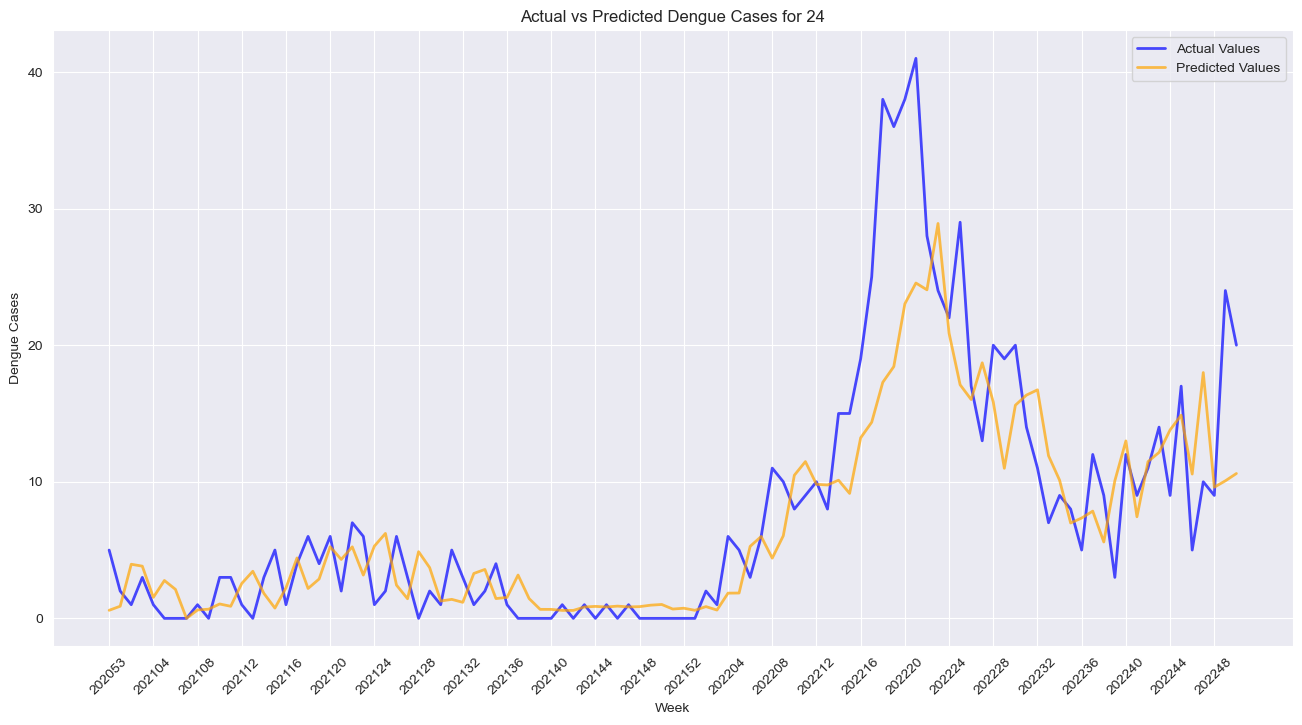

City: 27, RMSE: 4.788949002696439


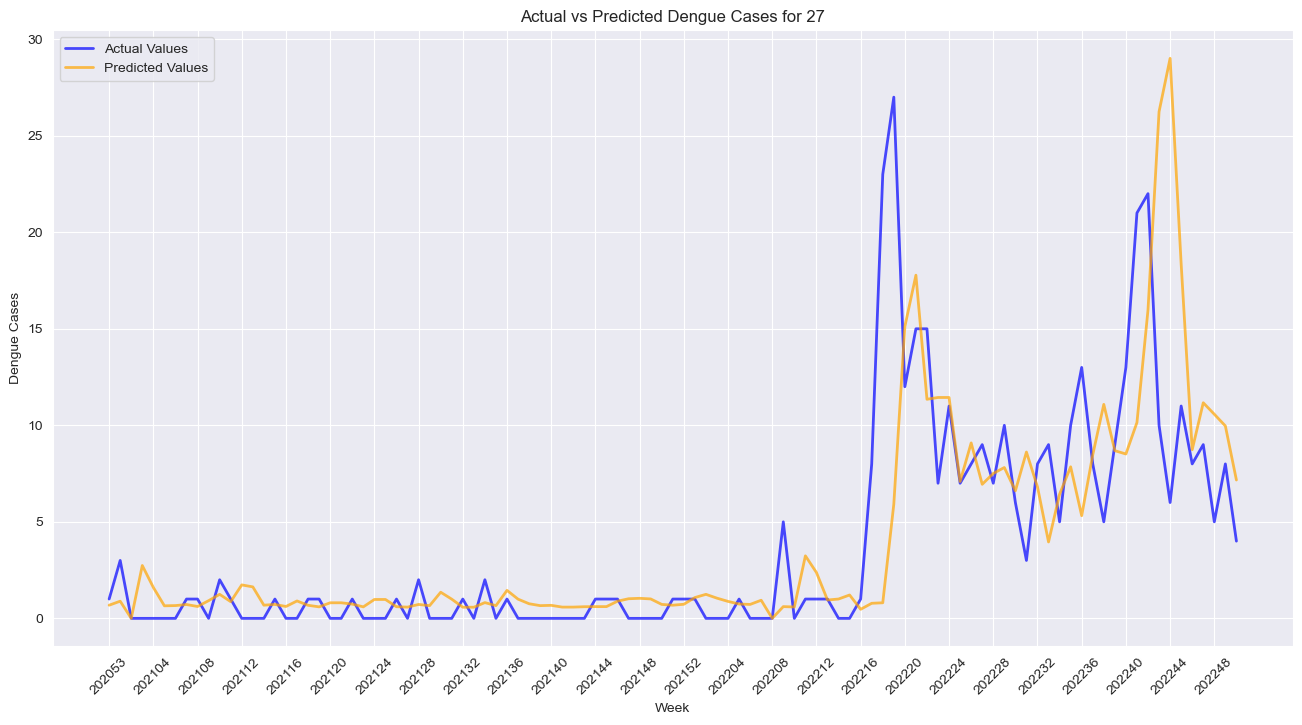

City: 28, RMSE: 2.295255471179247


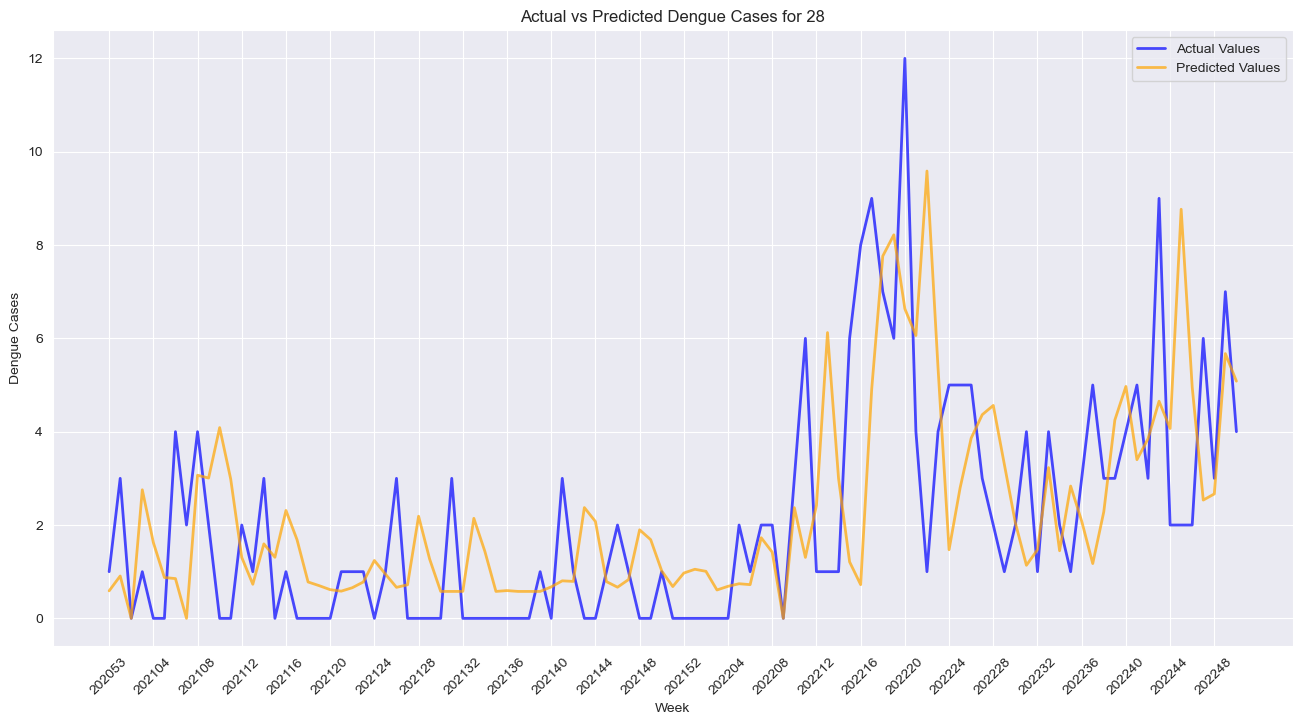

City: 29, RMSE: 5.677587273164933


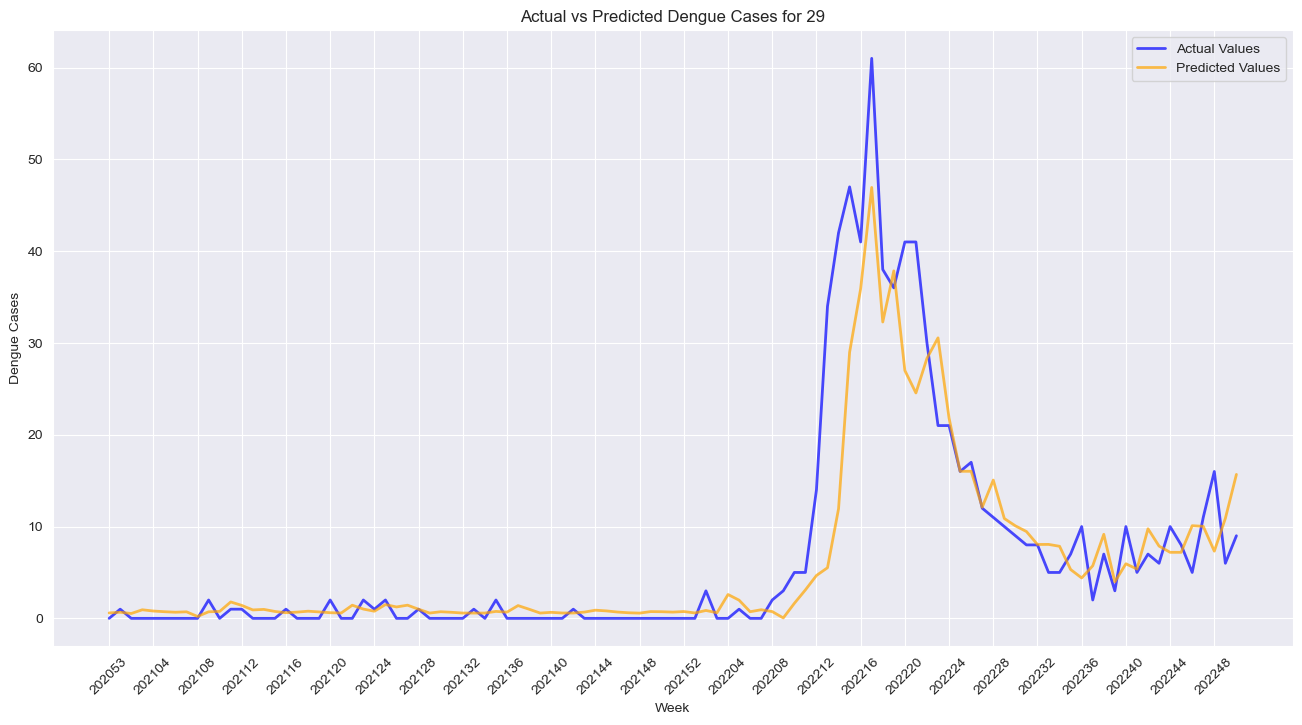

City: 30, RMSE: 2.100006891229947


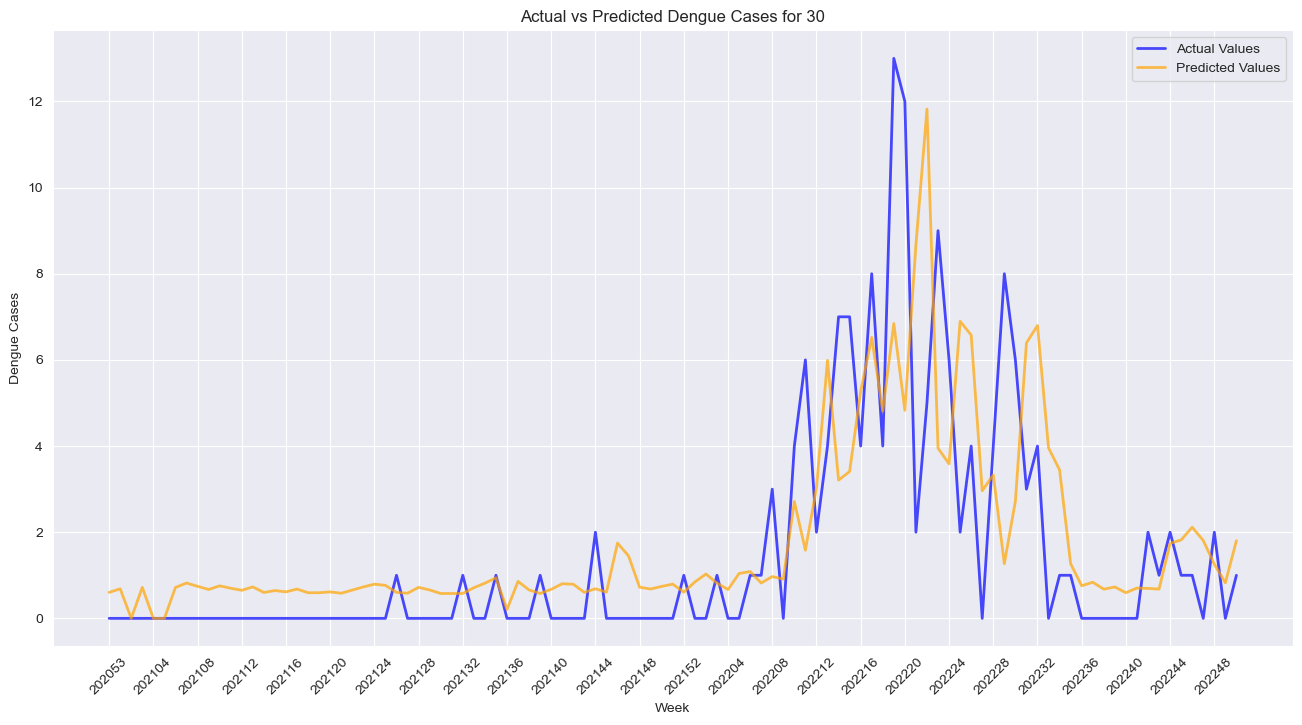

City: 31, RMSE: 4.933637381791457


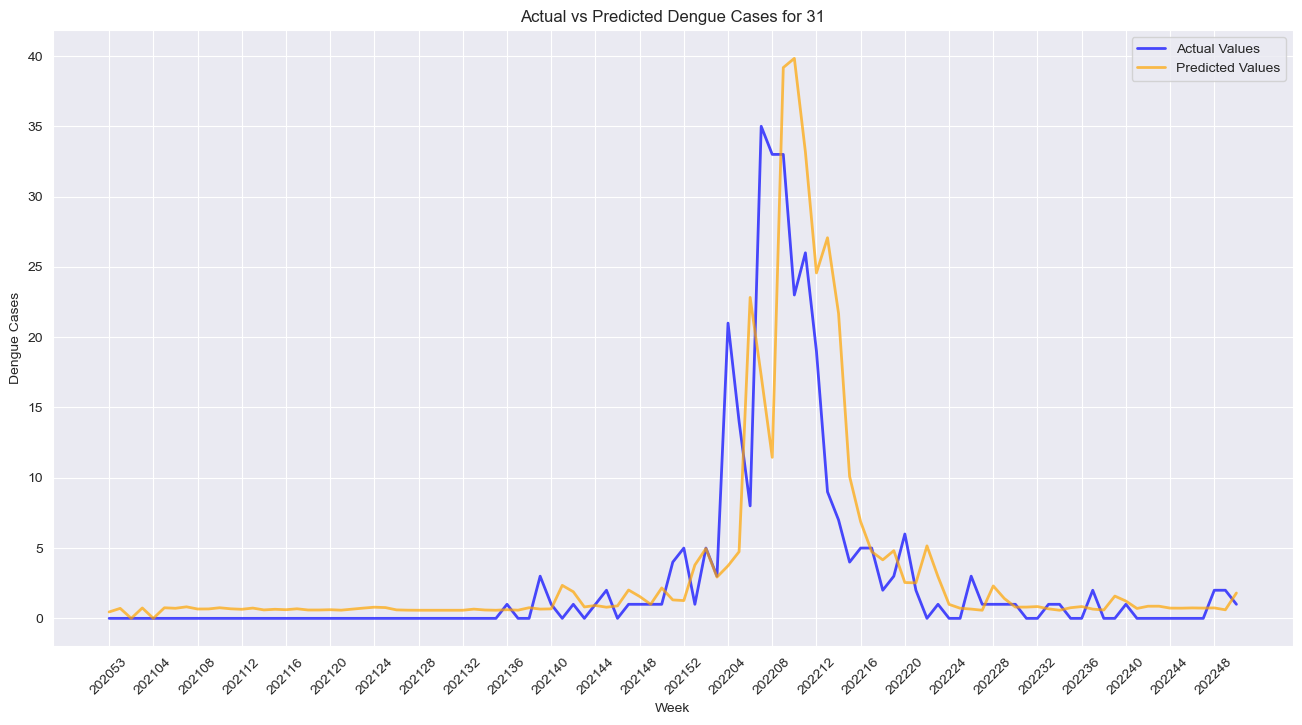

City: 32, RMSE: 9.568020791410751


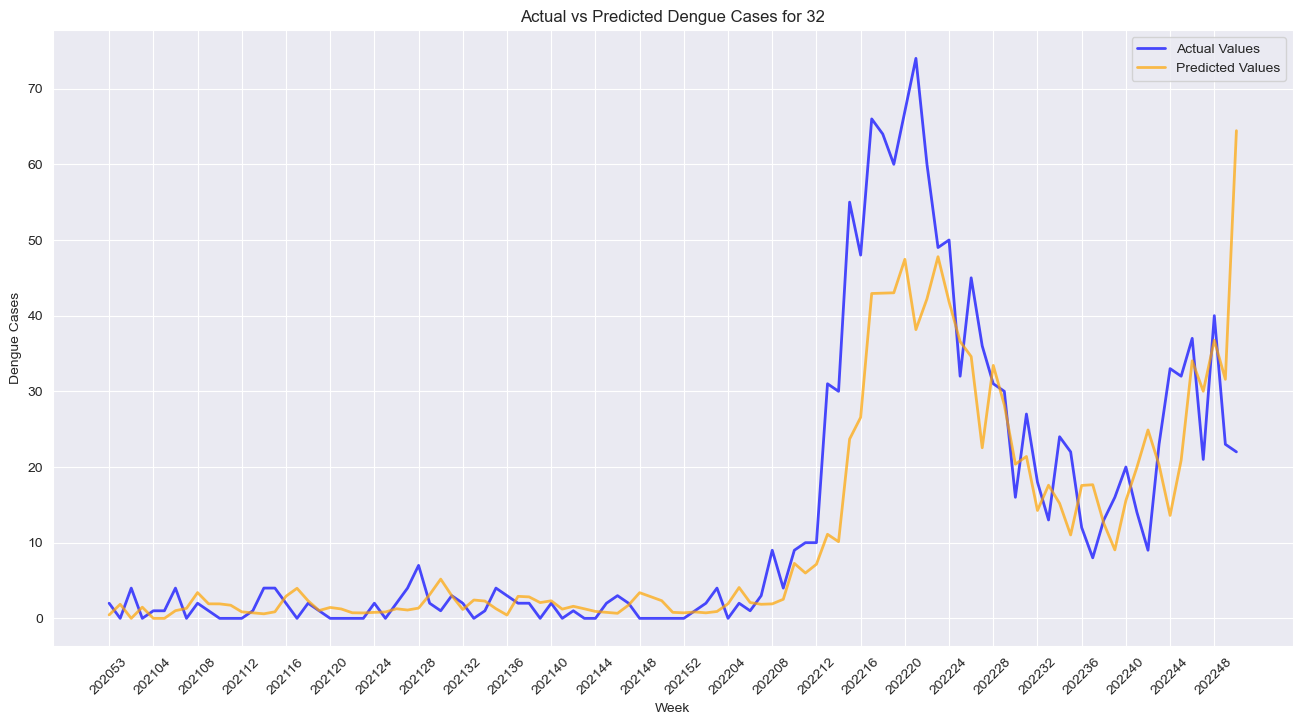

City: 34, RMSE: 2.4161639128229764


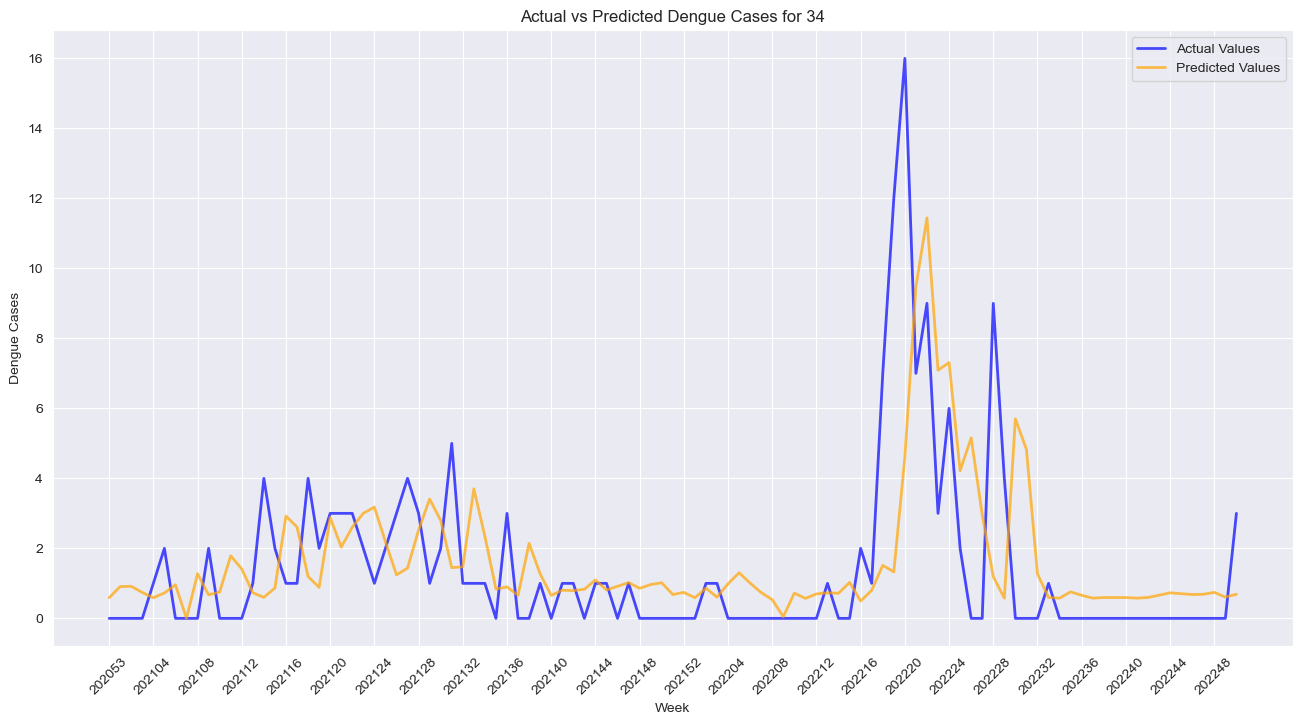

City: 36, RMSE: 10.036554710670815


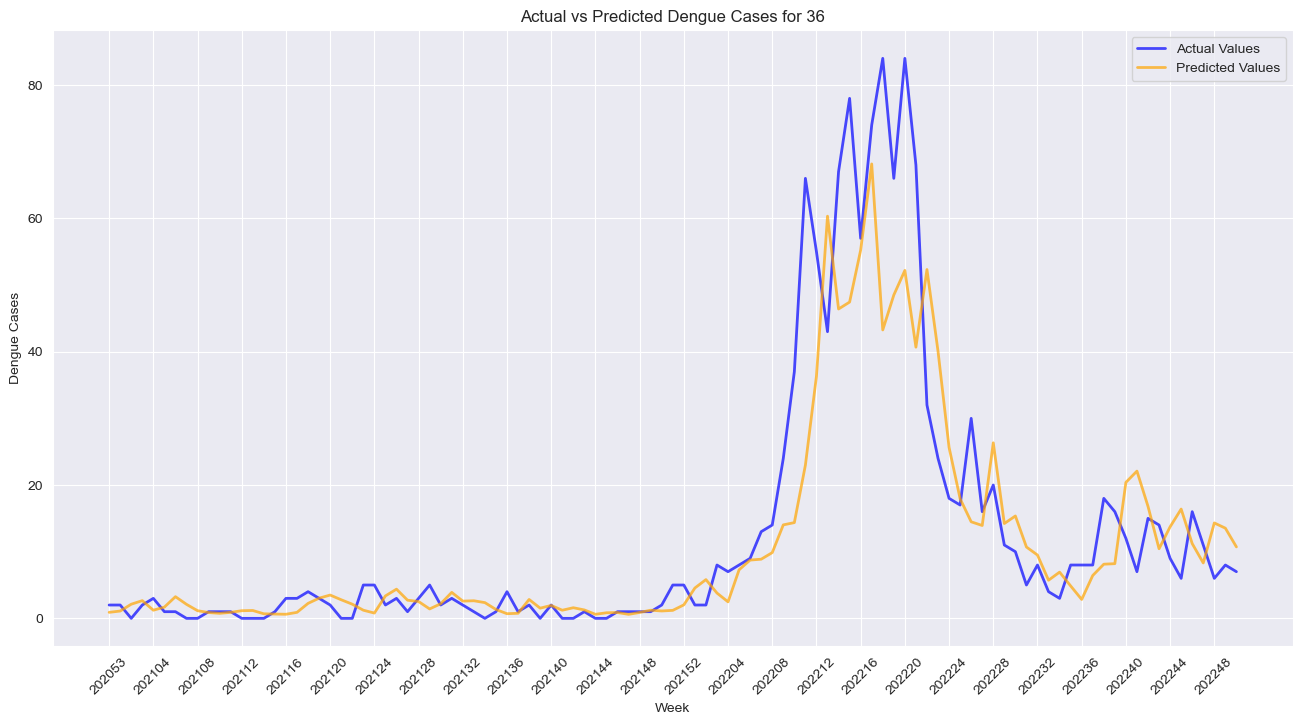

City: 38, RMSE: 1.7712740671232268


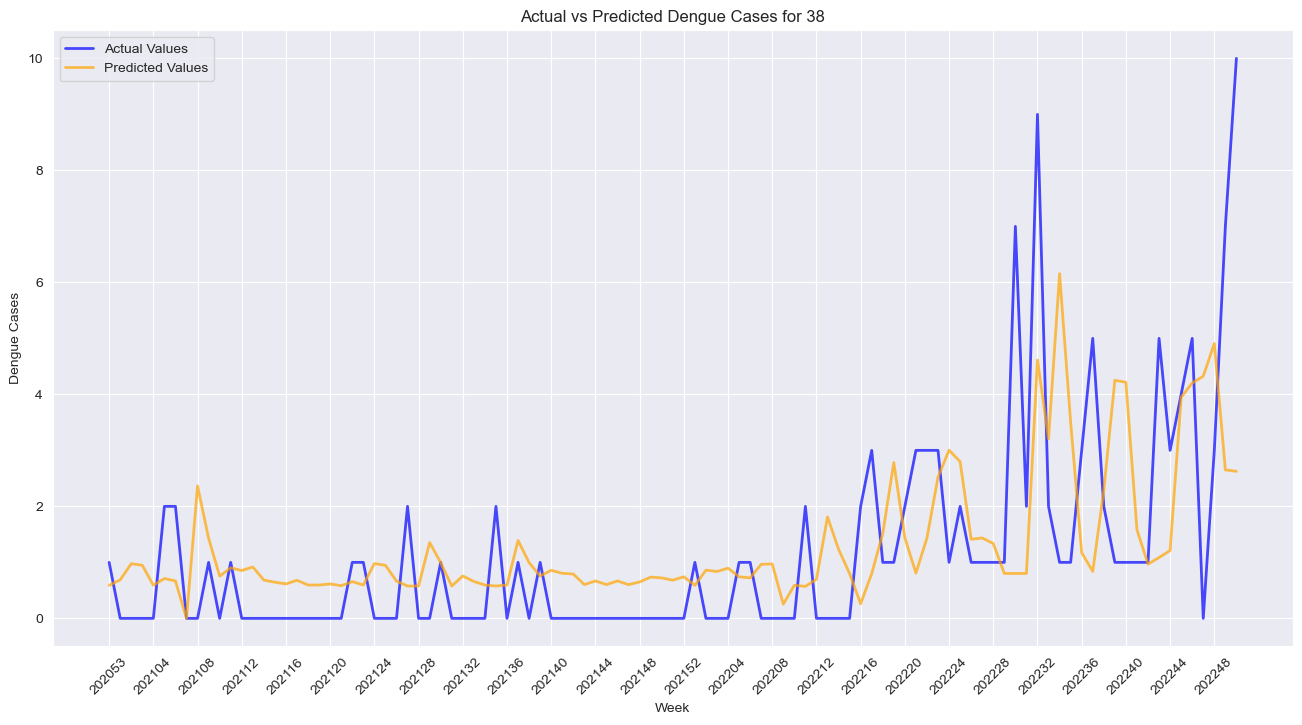

City: 47, RMSE: 4.811042793350044


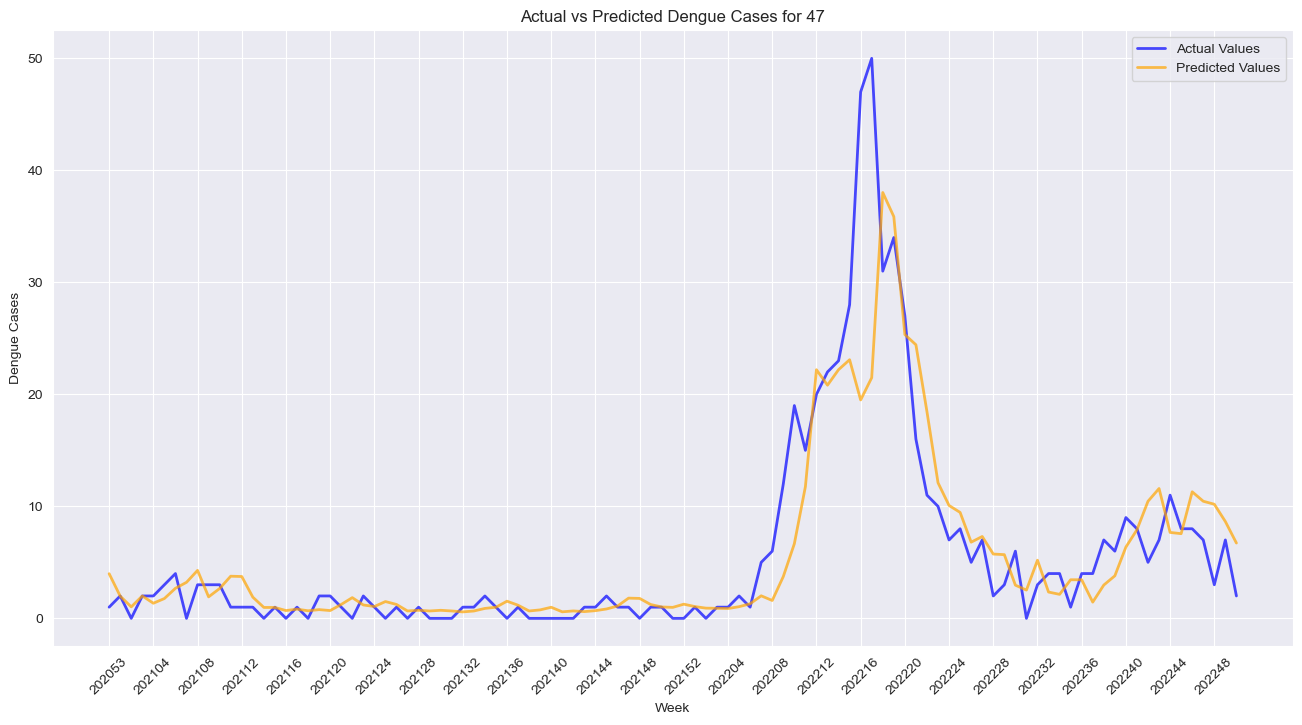

City: 48, RMSE: 2.7616885785716123


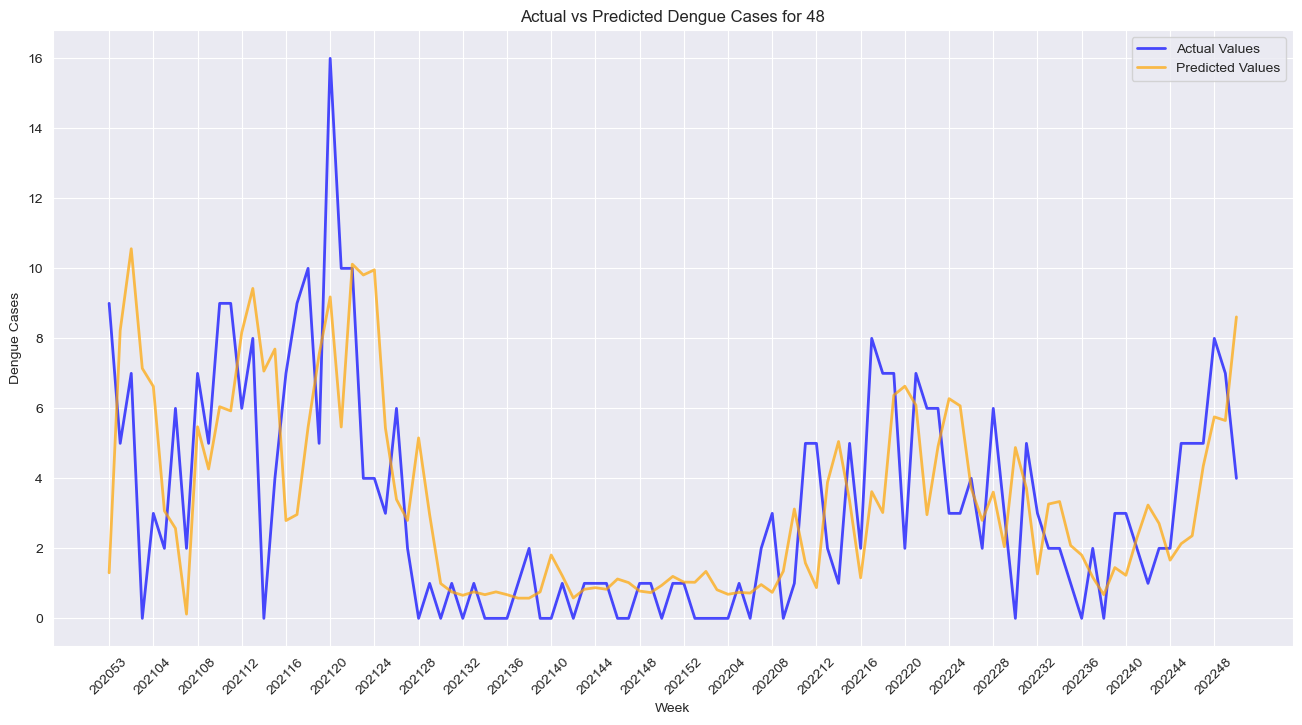

City: 50, RMSE: 6.652121621888737


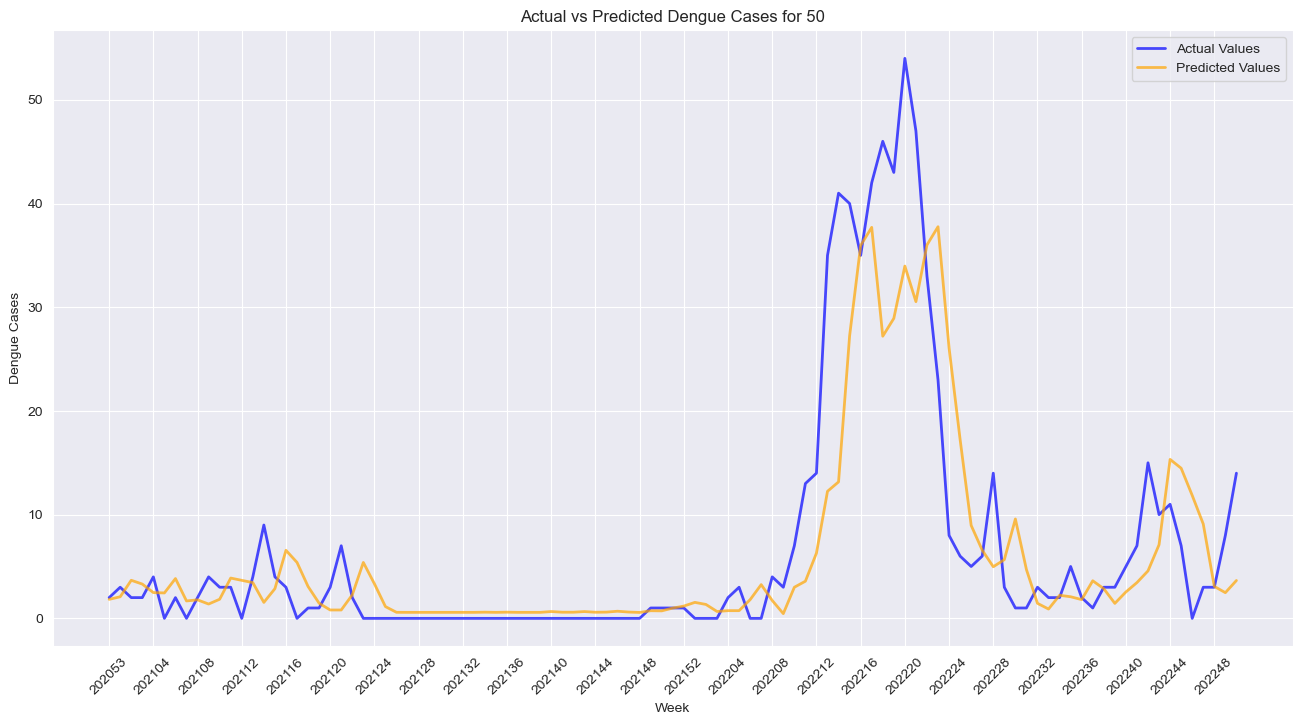

City: 53, RMSE: 1.818761240101575


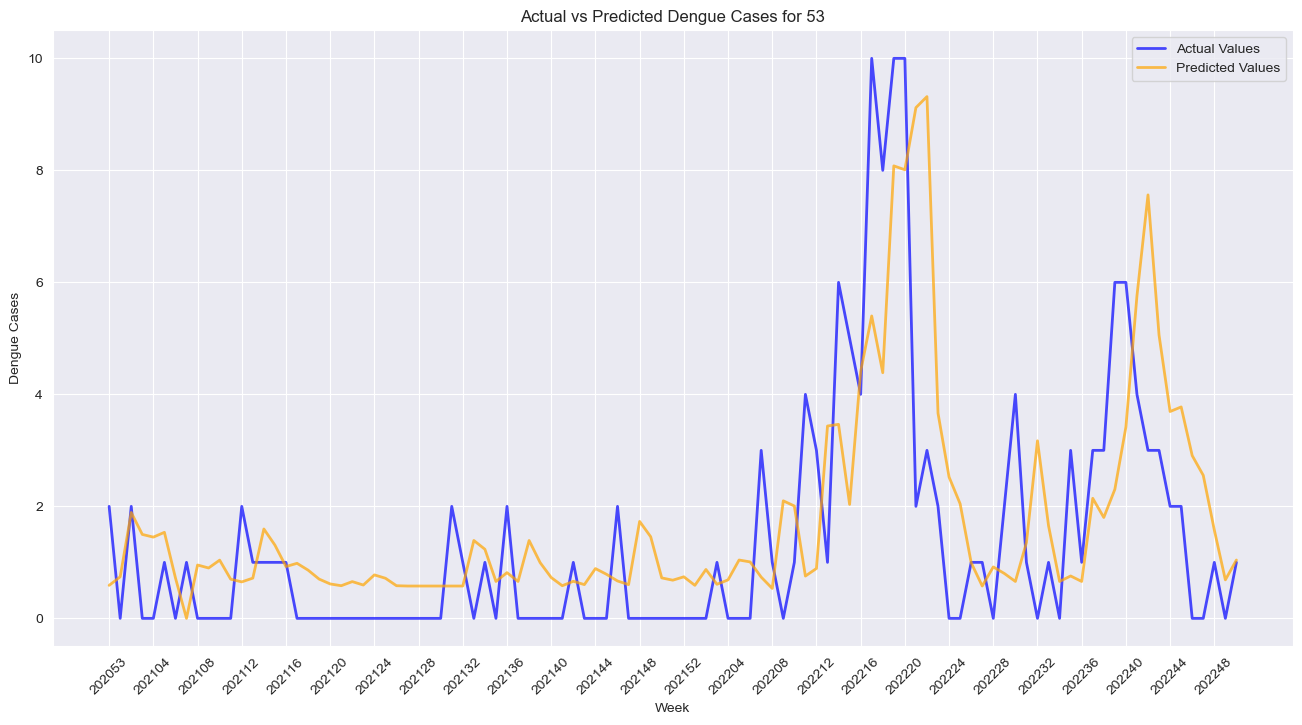

City: 55, RMSE: 2.3246654163865768


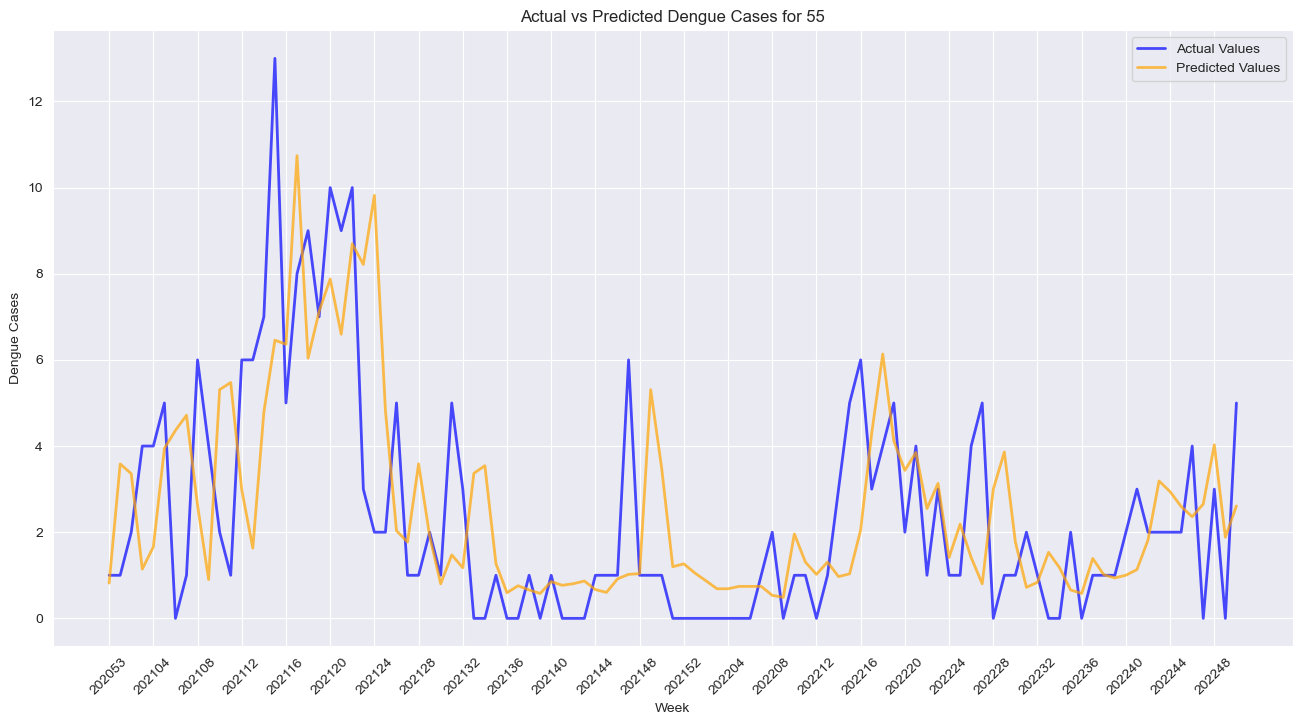

City: 56, RMSE: 3.83828469650825


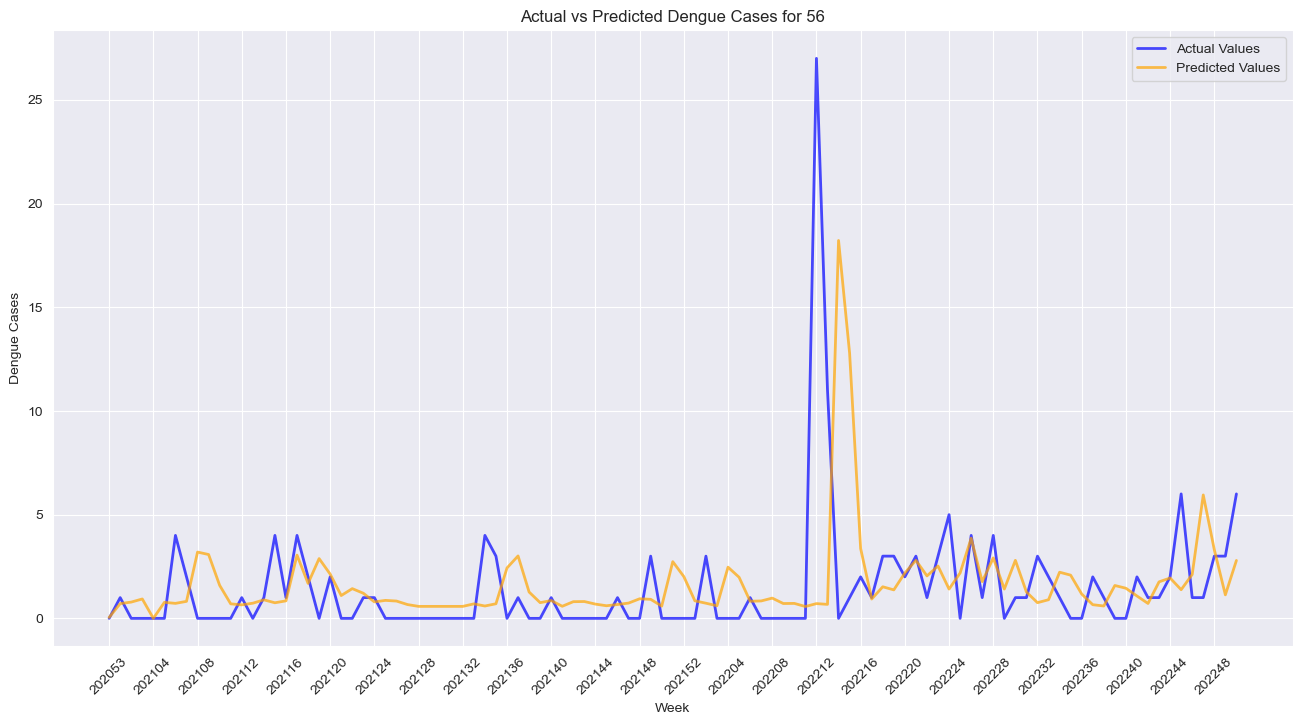

City: 58, RMSE: 2.3022036615153234


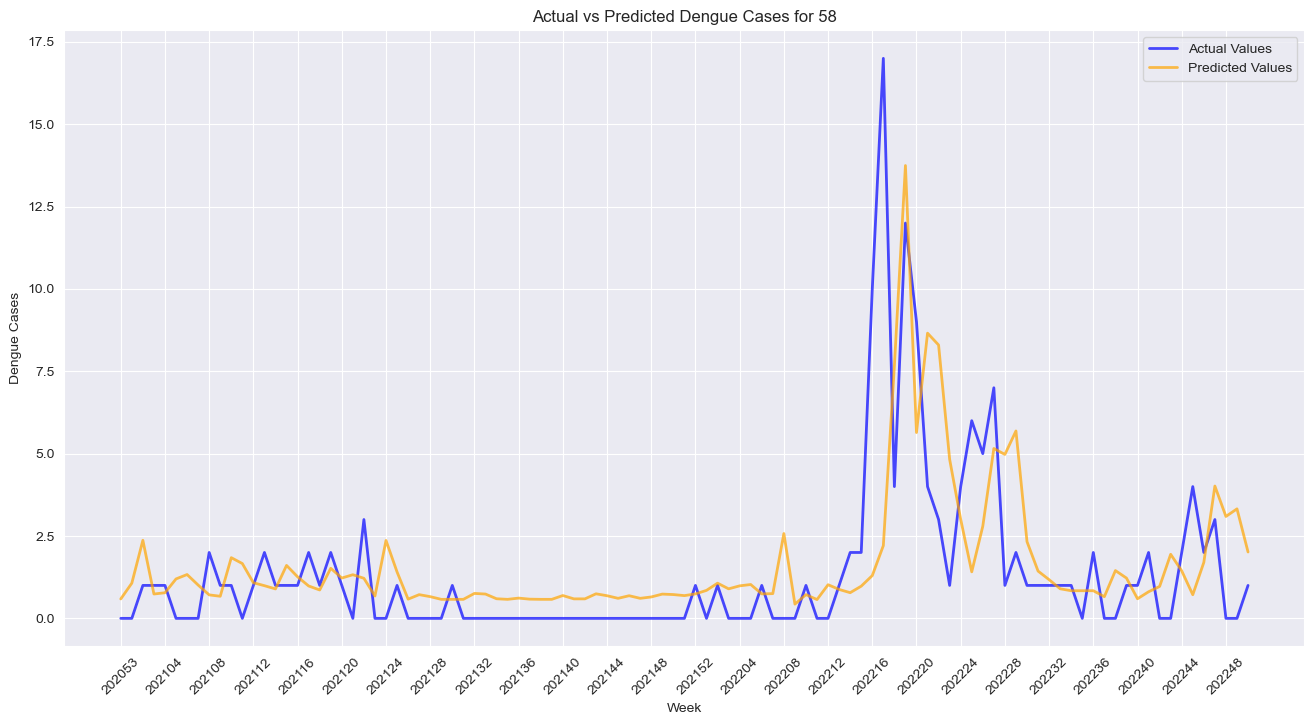

City: 60, RMSE: 3.1766519273430345


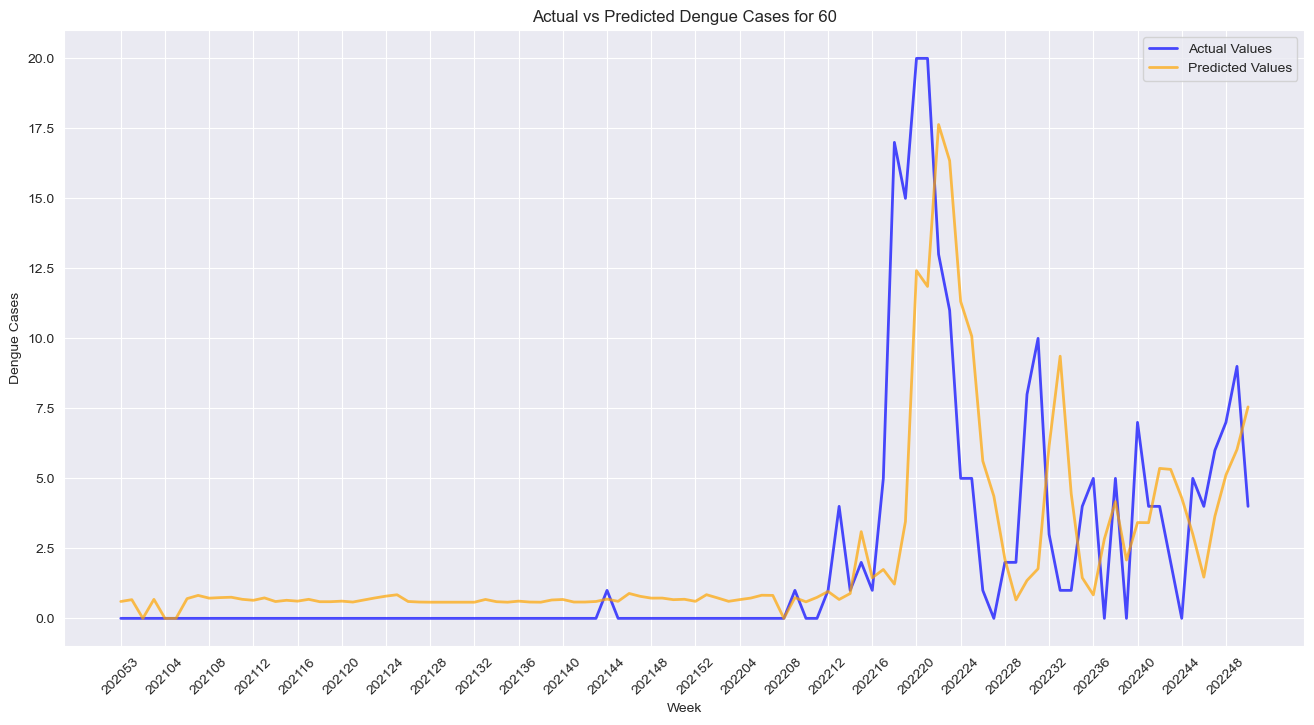

City: 61, RMSE: 10.31881976839616


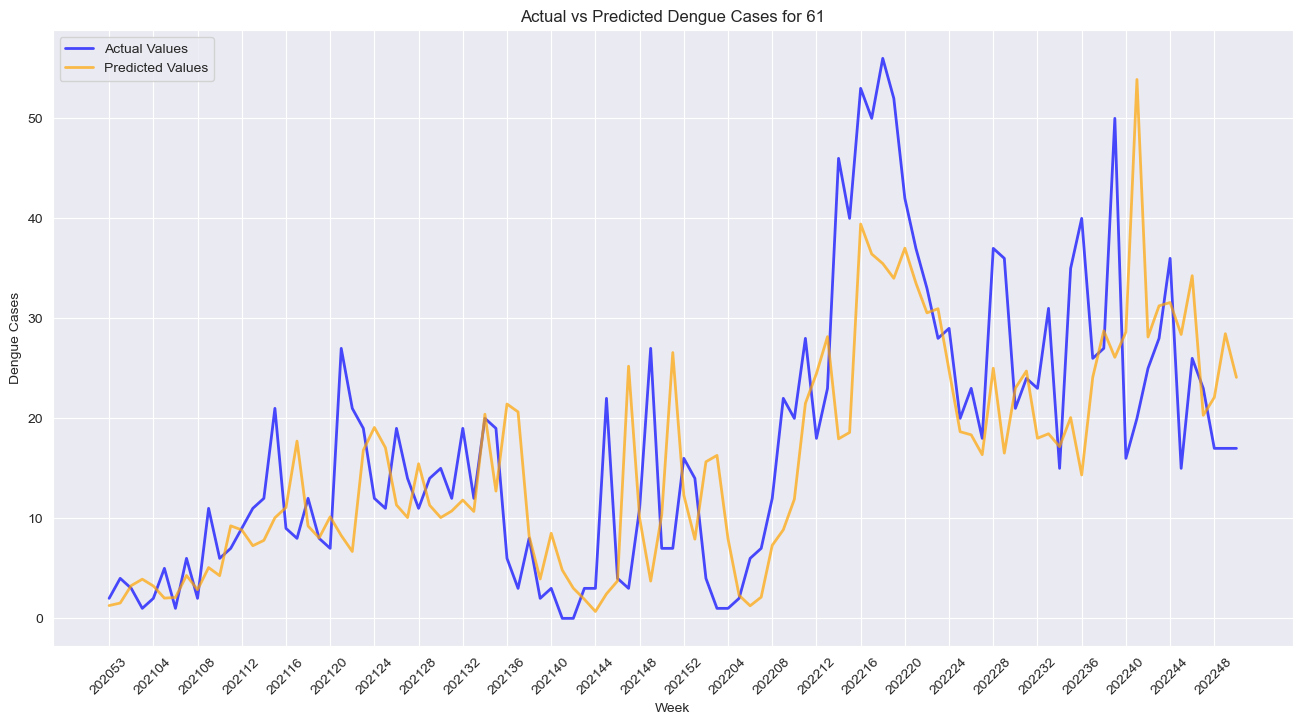

City: 65, RMSE: 8.231350822561806


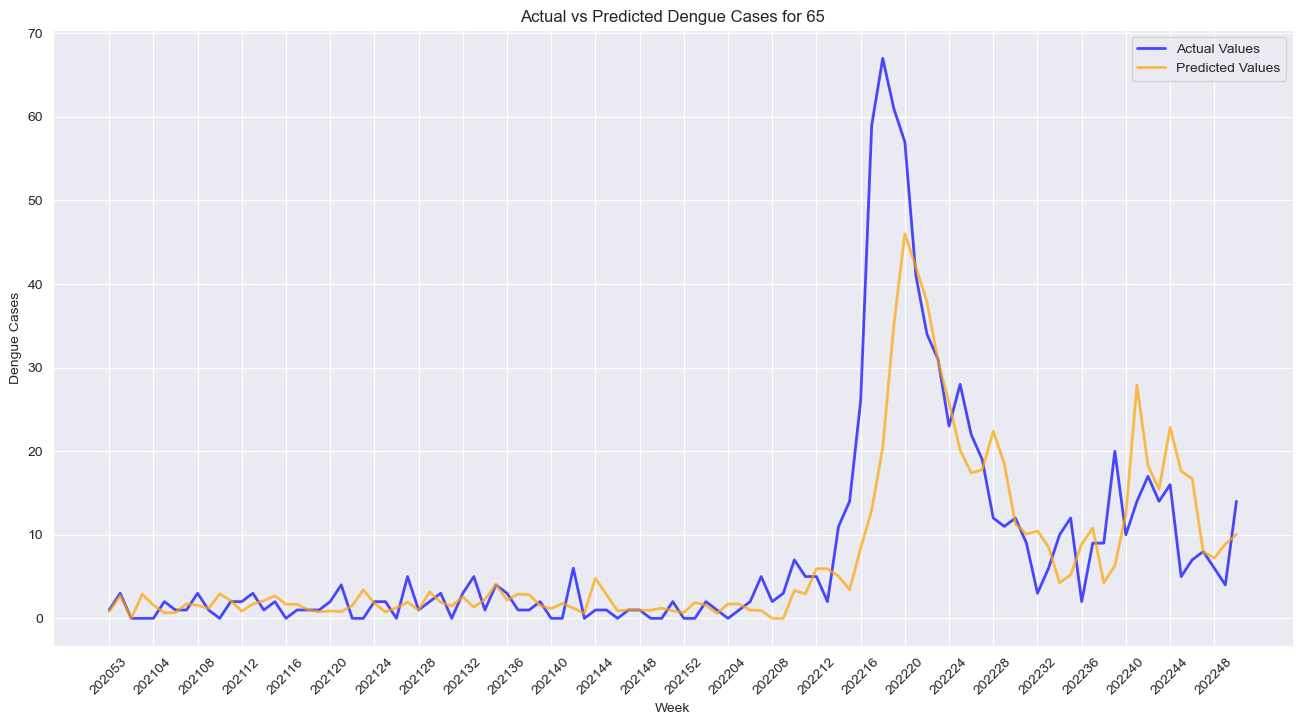

City: 66, RMSE: 43.9252363556515


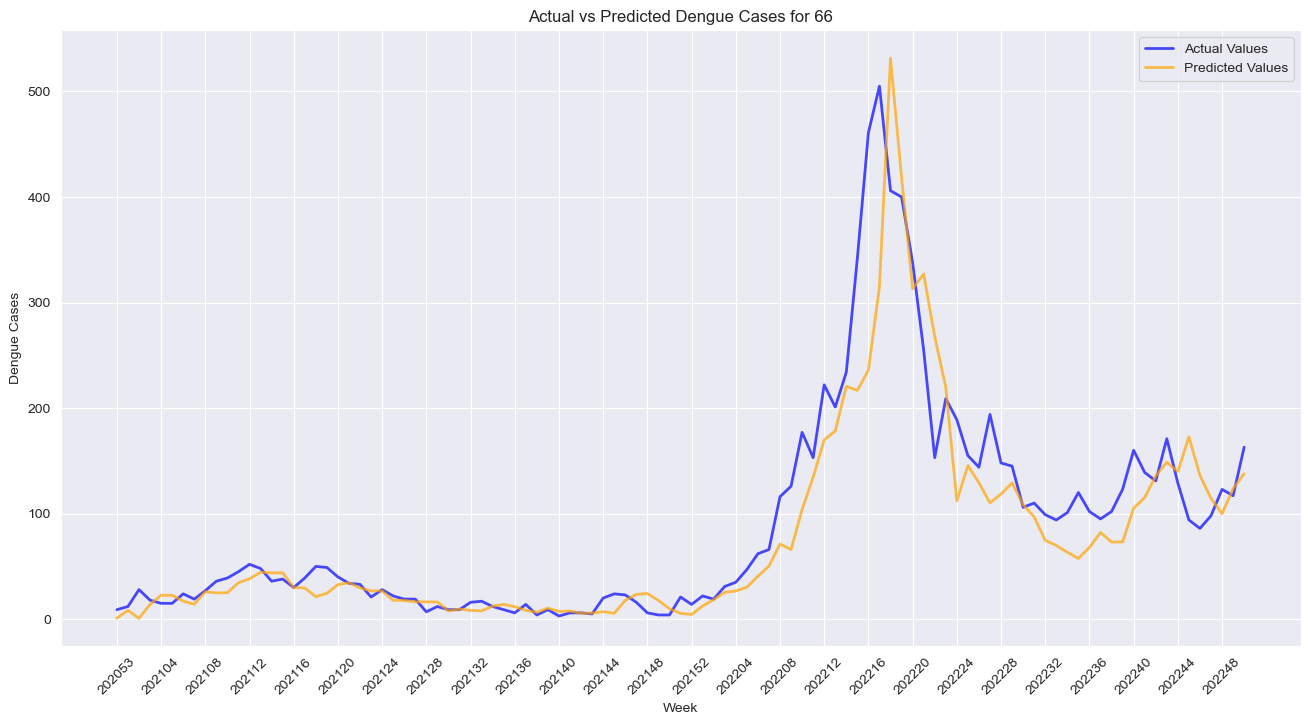

City: 68, RMSE: 4.834028250156174


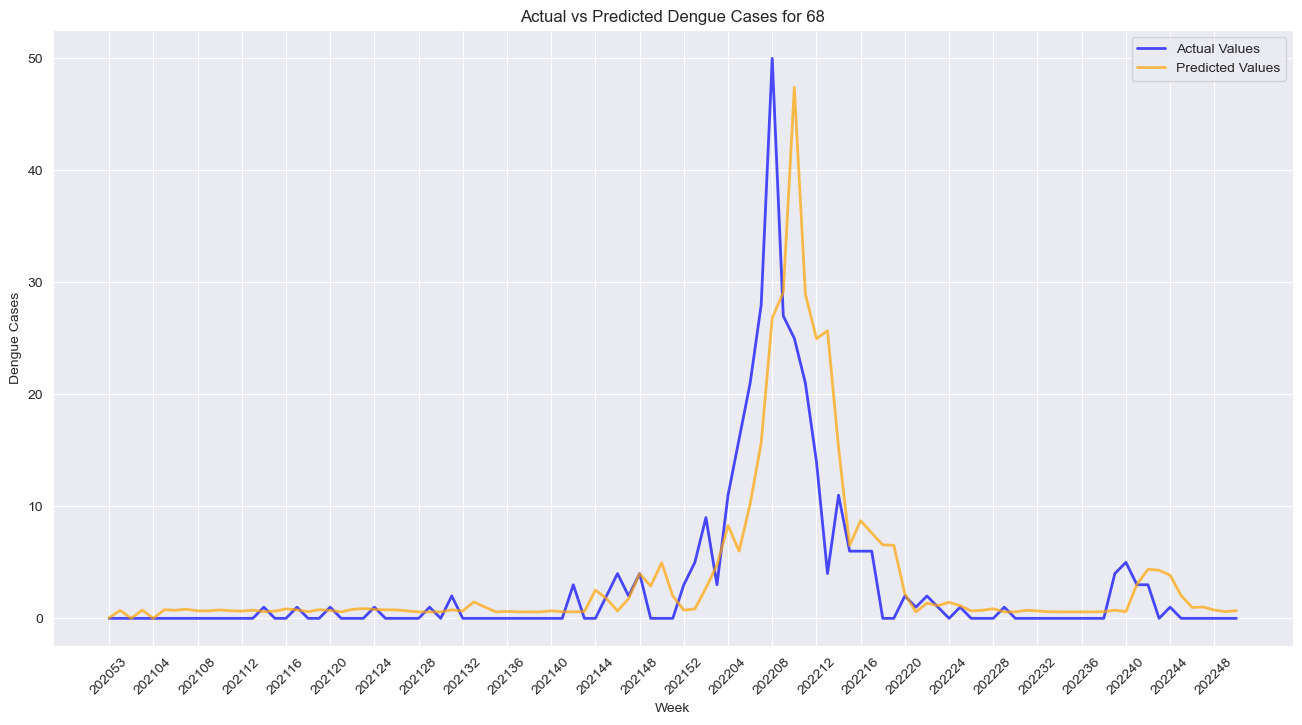

City: 76, RMSE: 2.45459138958287


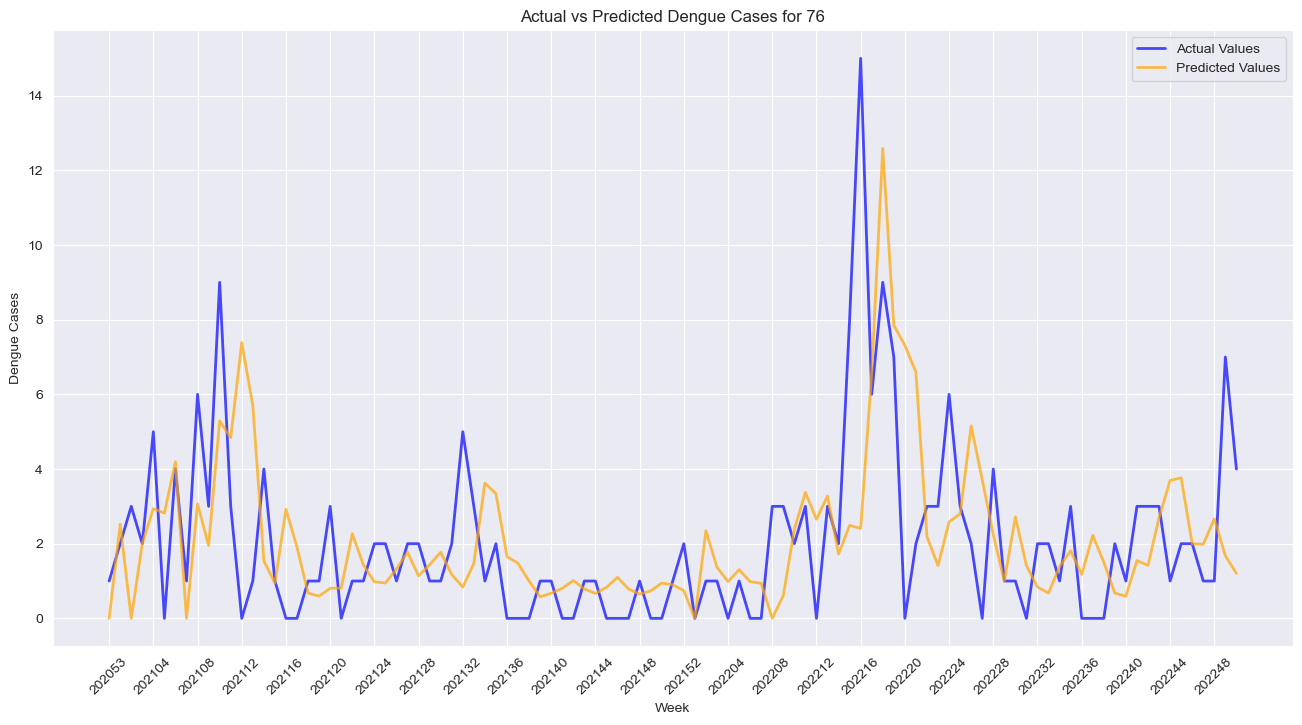

City: 80, RMSE: 2.5518406073112097


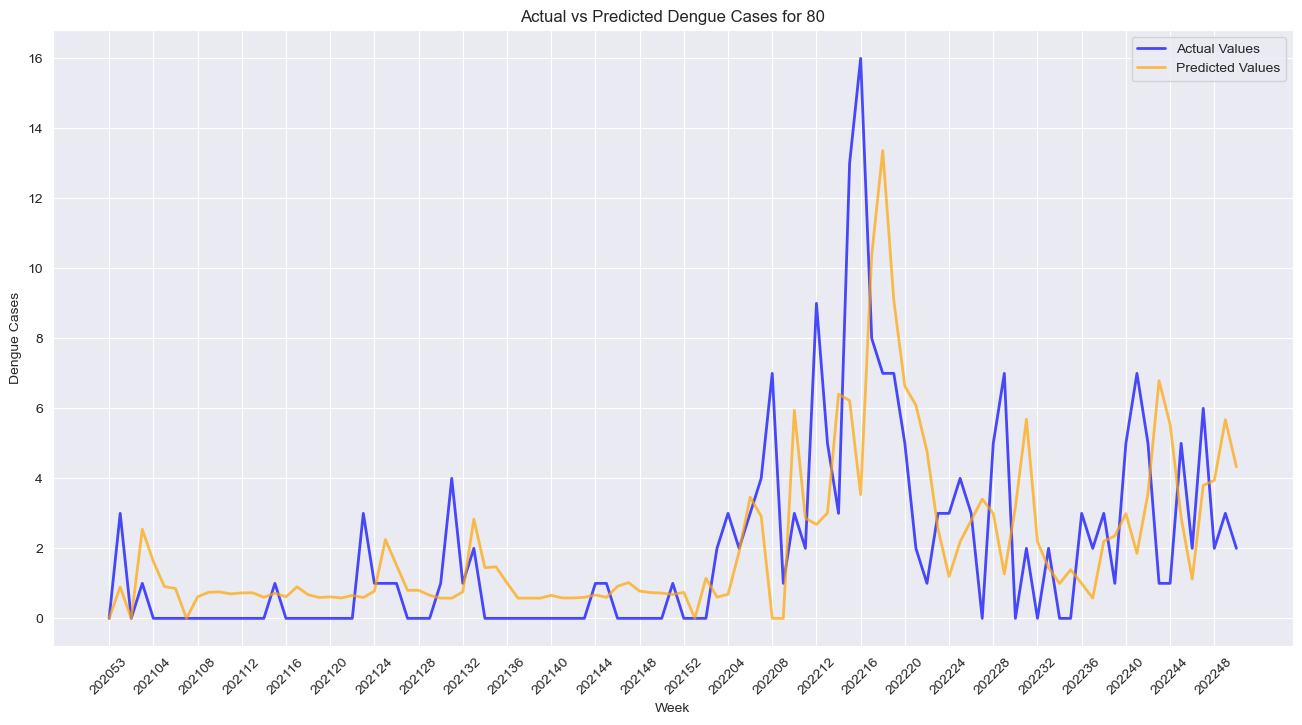

City: 81, RMSE: 1.790905581727429


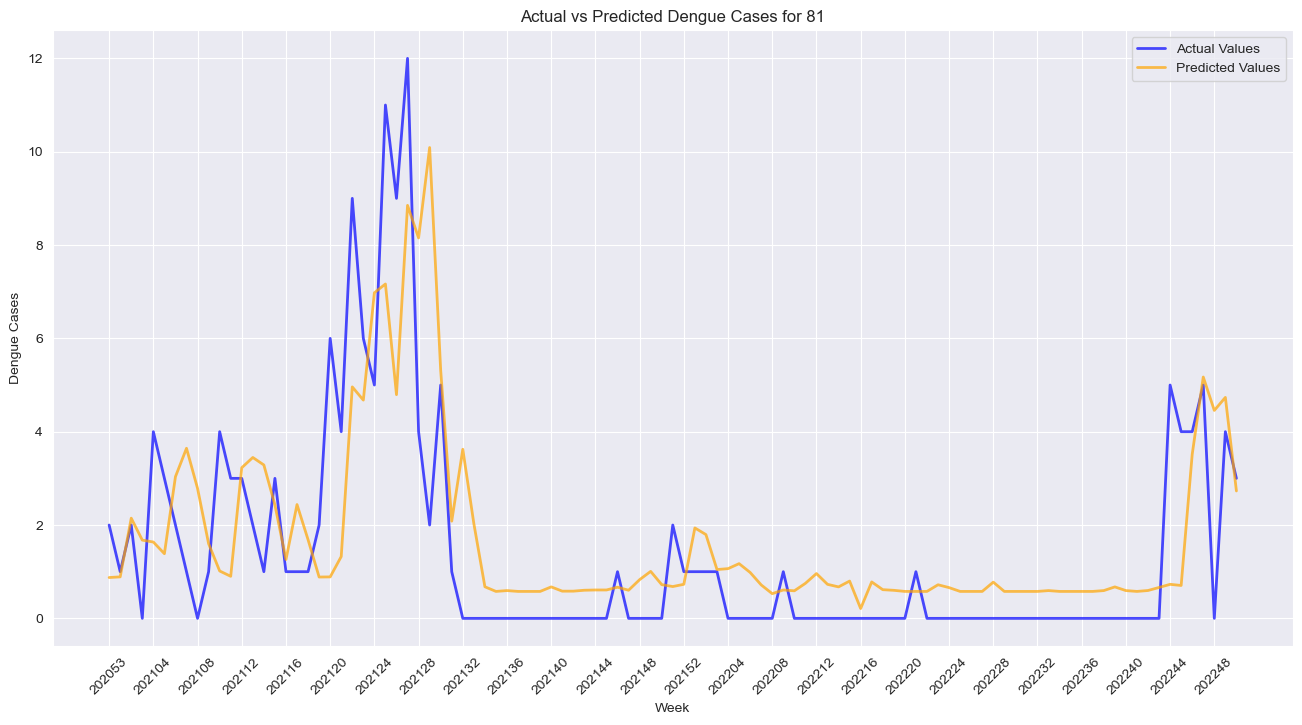

City: 70, RMSE: 4.434111149864723


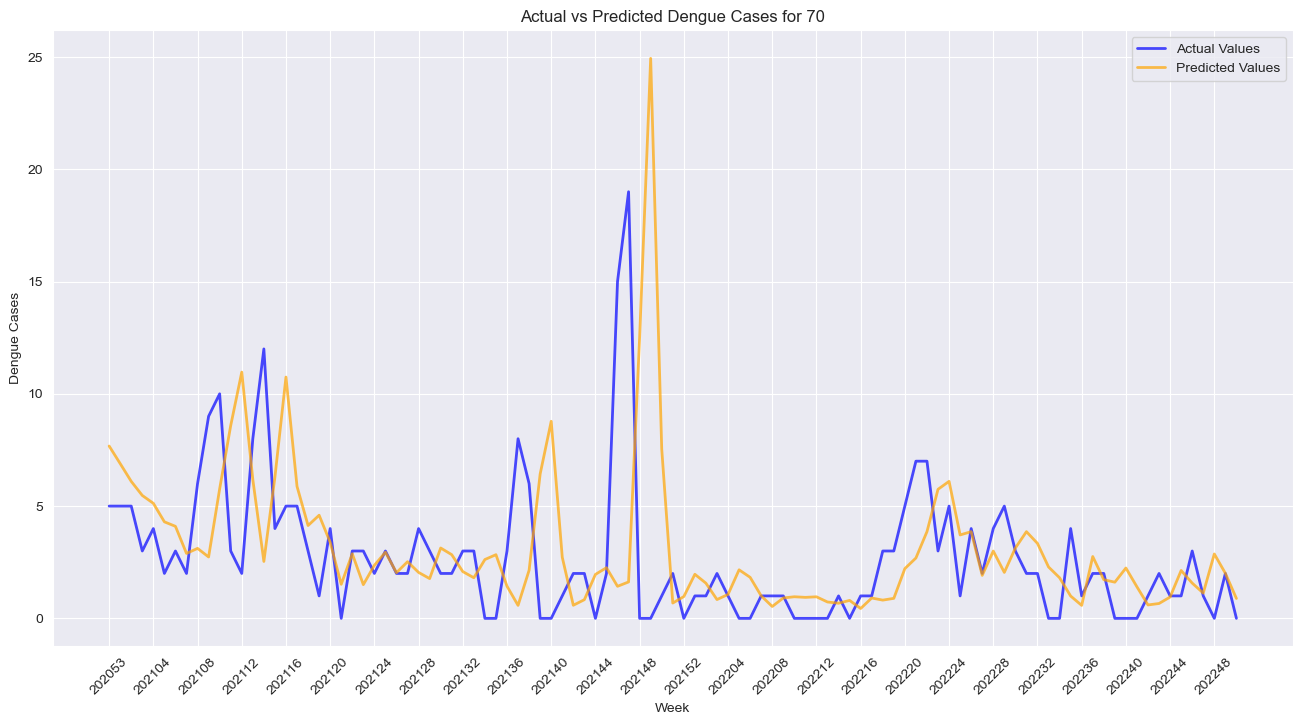

City: 71, RMSE: 3.5822179149651


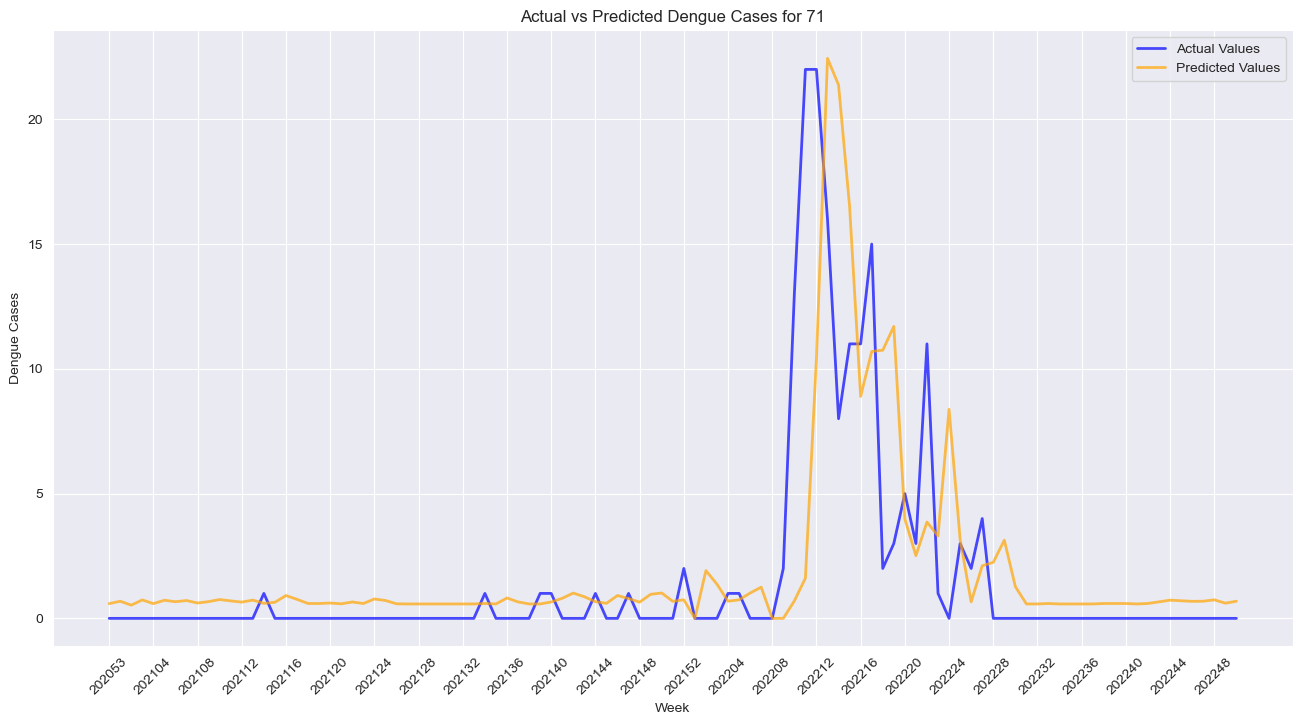

City: 87, RMSE: 2.593145713812693


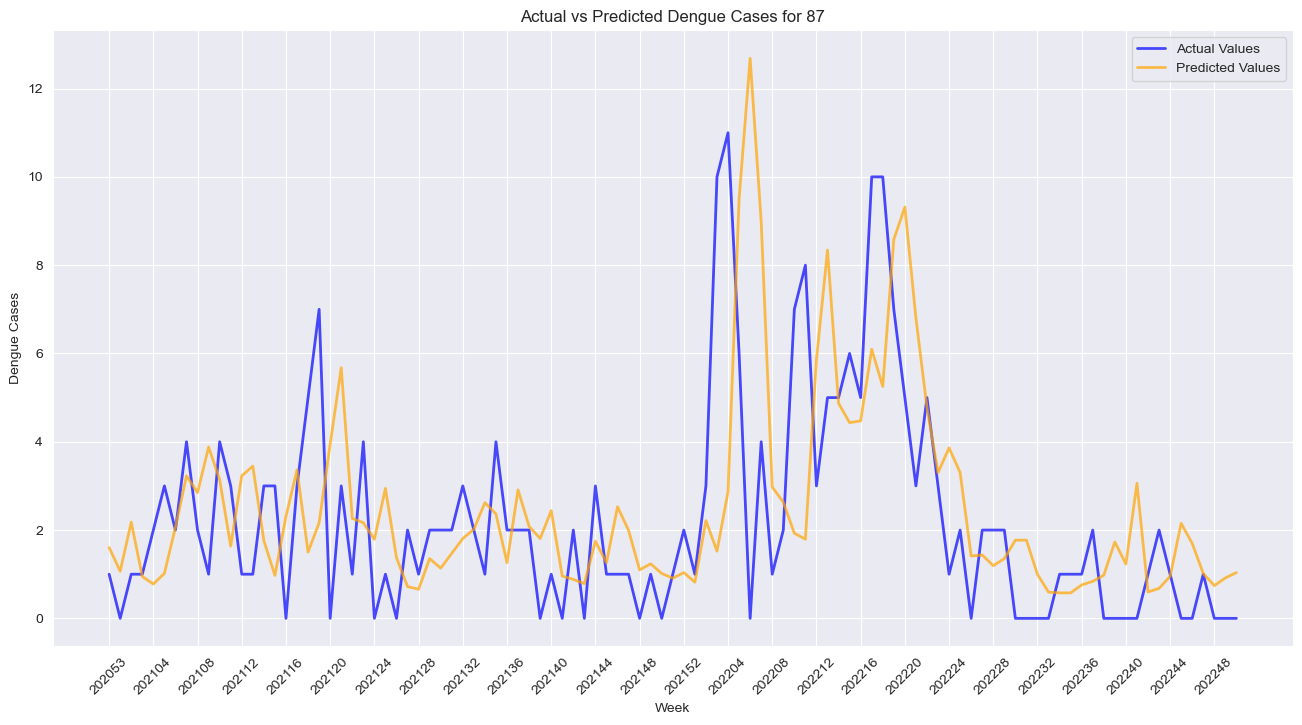

City: 89, RMSE: 2.31564525808316


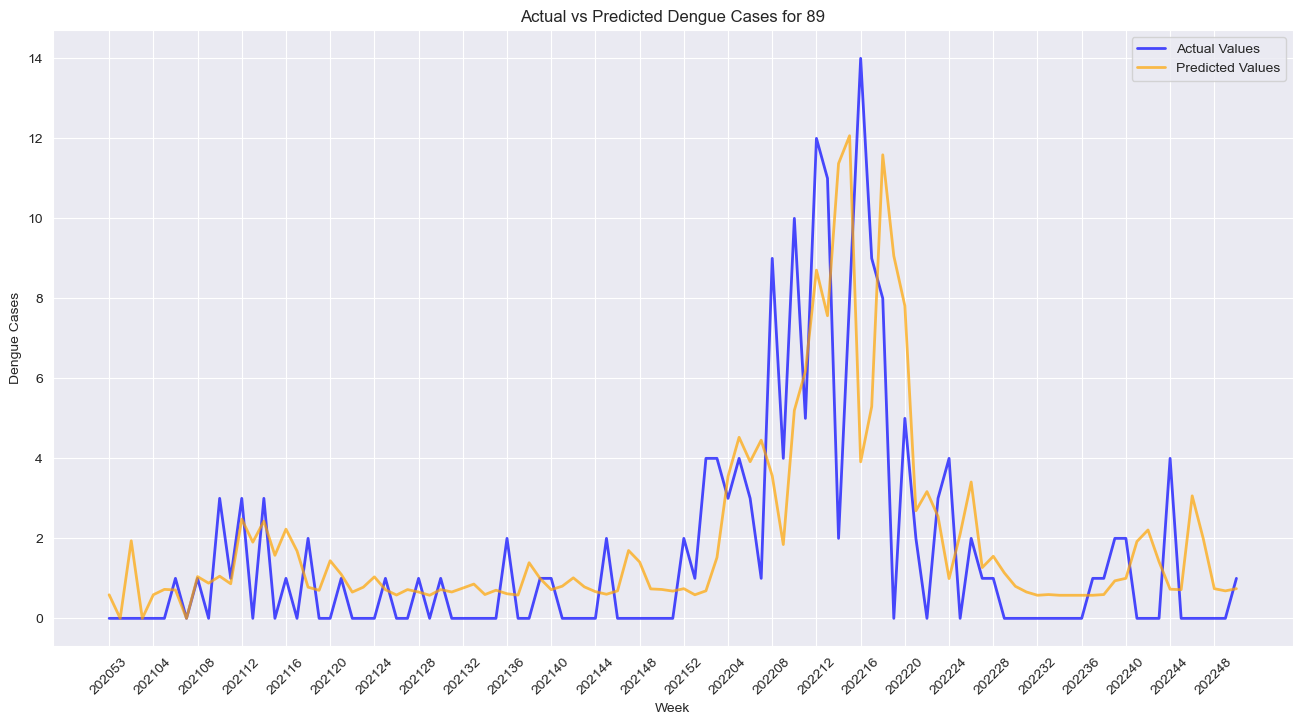

City: 90, RMSE: 3.560272375636582


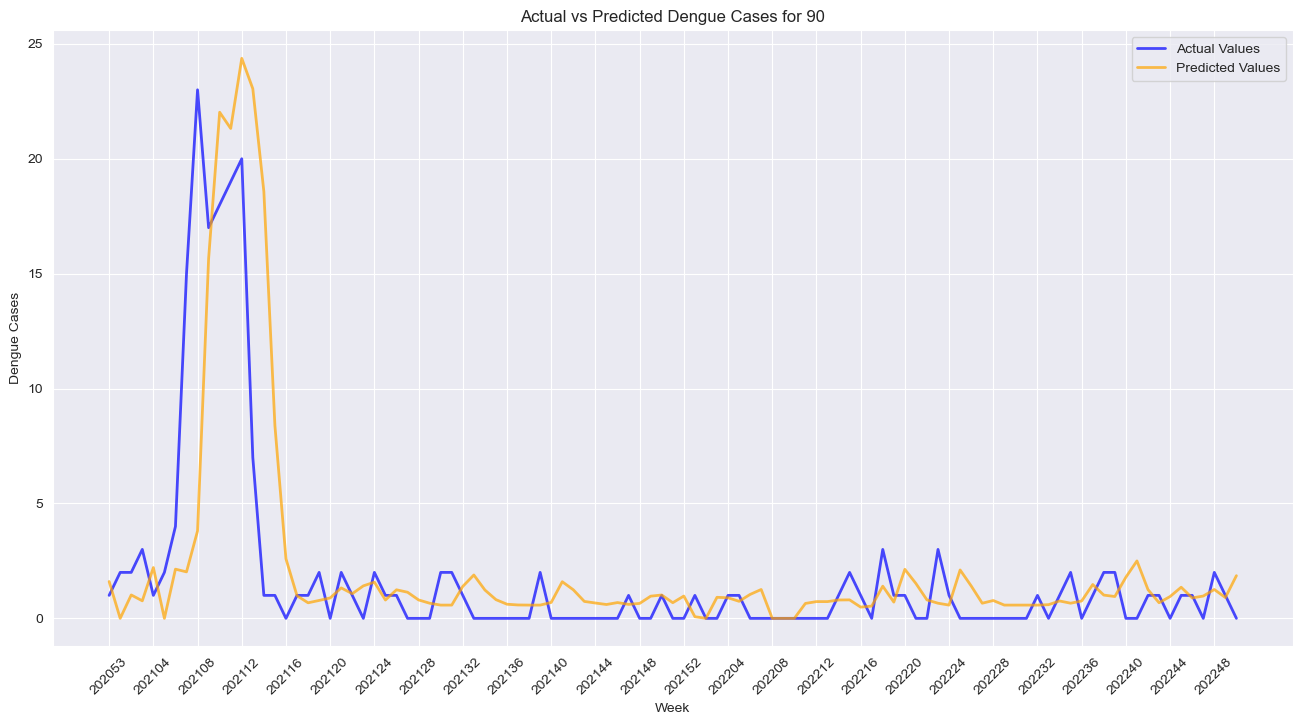

In [221]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'city_encoded' and 'week' are present in X_test
cities = X_test['city_encoded'].unique()

for city in cities:
    # Filter data for the city
    city_indices = X_test['city_encoded'] == city
    y_actual_city = y_actual[city_indices]
    y_pred_city = y_pred[city_indices]

    # Get weeks for the city and convert them to strings
    weeks_city = X_test['week'][city_indices].astype(str)

    # Skip the city if the maximum actual dengue cases are less than 10
    if np.max(y_actual_city) < 10:
        continue

    # Compute RMSE for the city
    rmse_city = np.sqrt(mean_squared_error(y_actual_city, y_pred_city))
    print(f'City: {city}, RMSE: {rmse_city}')

    # Plot for the city with weeks on the x-axis
    plt.figure(figsize=(16, 8))
    plt.plot(weeks_city, y_actual_city, label='Actual Values', color='blue', alpha=0.7, linewidth=2)
    plt.plot(weeks_city, y_pred_city, label='Predicted Values', color='orange', alpha=0.7, linewidth=2)
    plt.xlabel('Week')
    plt.ylabel('Dengue Cases')
    plt.title(f'Actual vs Predicted Dengue Cases for {city}')
    plt.legend()
    plt.grid(True)

    # Select every 4th week for x-axis labels
    ticks = weeks_city[::4]  # Select every 4th week
    plt.xticks(ticks, rotation=45)  # Rotate x-axis labels for readability
    plt.show()
